In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

# General imports
import yaml
import logging
import corner
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)

plt.style.use('paper')

In [2]:
paths_to_dir, paths_to_files = io.generate_paths()

14:57:16.936 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
14:57:16.937 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
14:57:16.938 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

In [3]:
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
paths_to_dir['output'] = '/Users/palmerio/Science_projects/GRB_population_model/model_outputs/best_populations'
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            ECLAIRs_config=instruments['ECLAIRs'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

# Nb_GRBs = int(float(config['Nb_GRBs']))
Nb_GRBs = int(1e6)

incl_samples, incl_instruments, incl_constraints = msc.create_config(config,
                                                                     samples,
                                                                     instruments,
                                                                     obs_constraints)

14:57:20.527 [DEBUG] Input configuration:
Nb_GRBs: 1e5
constraints:
- Stern
- EpGBM
- eBAT6
likelihood:
    epsilon: 0.001
output_dir: debugger
samples:
- Stern
- EpGBM
- eBAT6
- Swift
- ECLAIRs
- SHOALS
- GBM_sample
- BATSE_5B_sample
save_all_GRBs: false

14:57:20.530 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: -0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zeta: null
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM_Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47

14:57:20.536 [DEBUG] ==============================================
14:57:20.537 [DEBUG] ===           ECLAIRs instrument           ===
14:57:20.537 [DEBUG] ============================

In [4]:
# Generate the populations for the best model in each scenario or load the populations from files
# WARNING : this takes a long time to compute (at least 30 min with Nb_GRBs = 1e6)
##################

load_files = True

##################


np.random.seed(1)
model_names = ['kF_LN_nSFR',
               'k0_LN_nF', 
               'k05_LN_nF', 
               'k1_LN_nF', 
               'k2_LN_nF', 
               'kF_A_nSFR',
               'k0_A_nF', 
               'k05_A_nF',
               'k05_A_nF_2',
               'k1_A_nF', 
               'k1_A_nF_2', 
               'k2_A_nF']

model_names_ks = ['k0_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k2_A_nF']
# colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

parameters = {}
dfs = {}
results = {}
for mod in model_names:
    if load_files:
        print(f'Loading {mod}... ', end='')
        dfs[mod] = pd.read_parquet(f'../model_outputs_non-dockerized/best_populations/population_{mod}')
        print('Done')
    else:
        with open(paths_to_files['param'].parent / f'parameters_{mod}.yml', 'r') as f:
            parameters[mod] = yaml.safe_load(f)

        GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
        dfs[mod] = GRB_population.draw_GRB_properties(cosmo=cosmo, params=parameters[mod], run_mode=None)

        ph.calc_peak_photon_flux(dfs[mod], incl_instruments, ECLAIRs_prop)
        ph.calc_peak_energy_flux(dfs[mod], incl_instruments, ECLAIRs_prop)
        ph.calc_photon_fluence(dfs[mod], incl_instruments)
        ph.calc_energy_fluence(dfs[mod], incl_instruments)


Loading kF_LN_nSFR... Done
Loading k0_LN_nF... Done
Loading k05_LN_nF... Done
Loading k1_LN_nF... Done
Loading k2_LN_nF... Done
Loading kF_A_nSFR... Done
Loading k0_A_nF... Done
Loading k05_A_nF... Done
Loading k05_A_nF_2... Done
Loading k1_A_nF... Done
Loading k1_A_nF_2... Done
Loading k2_A_nF... Done


In [20]:
for mod in model_names:
    ph.calc_det_prob(dfs[mod], incl_samples, **ECLAIRs_prop)


11:33:06.316 [DEBUG] Starting calculations of detection probability...
11:33:06.317 [DEBUG] Stern sample:
11:33:06.337 [DEBUG] Done in 0.019 s
11:33:06.339 [DEBUG] EpGBM sample:
11:33:06.355 [DEBUG] Done in 0.015 s
11:33:06.355 [DEBUG] eBAT6 sample:
11:33:06.396 [DEBUG] Done in 0.040 s
11:33:06.399 [DEBUG] Swift sample:
11:33:06.411 [DEBUG] Done in 0.010 s
11:33:06.412 [DEBUG] ECLAIRs sample:
11:33:56.895 [DEBUG] Done in 50.483 s
11:33:56.896 [DEBUG] SHOALS sample:
11:33:56.907 [DEBUG] Done in 0.010 s
11:33:56.908 [DEBUG] GBM_sample sample:
11:33:56.916 [DEBUG] Done in 0.007 s
11:33:56.916 [DEBUG] BATSE_5B_sample sample:
11:33:56.942 [DEBUG] Done in 0.025 s
11:33:56.943 [DEBUG] Starting calculations of detection probability...
11:33:56.944 [DEBUG] Stern sample:
11:33:56.973 [DEBUG] Done in 0.028 s
11:33:56.974 [DEBUG] EpGBM sample:
11:33:57.002 [DEBUG] Done in 0.027 s
11:33:57.003 [DEBUG] eBAT6 sample:
11:33:57.041 [DEBUG] Done in 0.037 s
11:33:57.042 [DEBUG] Swift sample:
11:33:57.069

In [24]:
dfs[mod]

,z,L,Ep,alpha,beta,ktild,D_L,Epobs,pht_pflx_BATSE,t90,...,pdet_Stern,pdet_EpGBM,pdet_eBAT6,pdet_Swift,pdet_ECLAIRs_tot,pdet_ECLAIRs_pht_flnc,pdet_ECLAIRs_pht_cts,pdet_SHOALS,pdet_GBM_sample,pdet_BATSE_5B_sample
0,1.372,1.164704e+51,147.359024,0.695402,2.61837,1.130908,9850.693837,62.124378,0.269436,15.590607,...,1.0,0.0,0.0,1.0,0.248169,0.246720,0.248169,0.0,0.0,0.0
1,6.058,2.280488e+52,1013.198160,0.654818,2.27331,0.743257,59638.563080,143.553154,0.089084,22.463166,...,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,1.941,2.355724e+51,249.853906,0.723803,2.13198,0.394282,15164.023589,84.955425,0.092444,4.862724,...,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,1.663,6.320831e+50,125.210788,0.321211,2.61339,1.776918,12518.916992,47.018696,0.086242,73.474117,...,1.0,0.0,0.0,1.0,0.271439,0.271439,0.000000,0.0,0.0,0.0
4,0.945,2.588084e+50,180.734704,-0.037648,2.33601,1.853846,6182.507246,92.922727,0.125322,8.173762,...,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3.839,1.649743e+51,342.168456,0.796451,2.53990,0.934934,34783.920413,70.710572,0.029245,12.147161,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
999996,0.738,2.563628e+50,854.558095,1.026830,2.33238,0.538762,4546.613172,491.690504,0.101171,6.066868,...,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
999997,0.641,1.106811e+51,154.375603,0.957997,2.46597,0.706819,3821.316400,94.074103,1.492445,5.418096,...,1.0,1.0,1.0,1.0,0.773782,0.773782,0.744077,0.0,1.0,1.0
999998,2.322,1.469934e+51,180.023943,0.841180,2.12157,0.324034,18911.041242,54.191434,0.034169,13.500566,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [23]:
# Save the best populations to avoid recalculating each time
if not load_files:
    for mod in model_names:
        dfs[mod].to_parquet(paths_to_dir['output'] + f'/population_{mod}')

################# kF_LN_nSFR #####################
18:16:42.263 [INFO] Global GRB rate: 1137.9500015101319
18:16:42.299 [INFO]           Stern chi2: 2.5598e+01
18:16:42.300 [INFO]  Stern normalization: 2.7811e-03 yr-1
18:16:42.301 [INFO]  Simulation duration: 3.5957e+02 yr
18:16:42.302 [INFO]            ndot_LGRB: 2.7811e+03 LGRB/yr


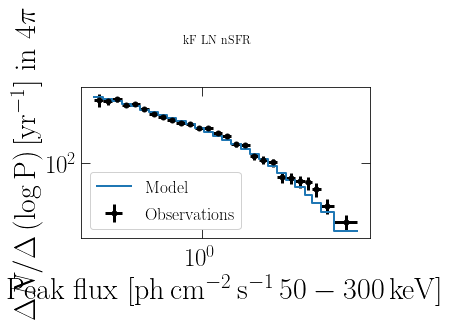

################################################
################# k0_LN_nF #####################
18:16:43.718 [INFO] Global GRB rate: 1137.9500015101319
18:16:43.730 [INFO]           Stern chi2: 3.1422e+01
18:16:43.730 [INFO]  Stern normalization: 9.2986e-03 yr-1
18:16:43.731 [INFO]  Simulation duration: 1.0754e+02 yr
18:16:43.732 [INFO]            ndot_LGRB: 9.2986e+03 LGRB/yr


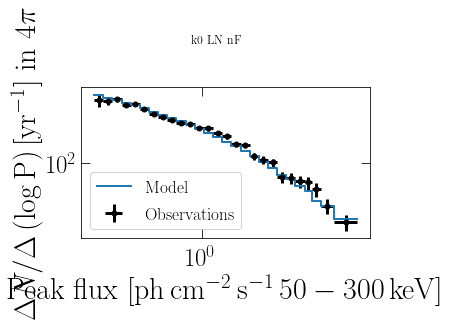

################################################
################# k05_LN_nF #####################
18:16:44.127 [INFO] Global GRB rate: 1137.9500015101319
18:16:44.148 [INFO]           Stern chi2: 2.6268e+01
18:16:44.149 [INFO]  Stern normalization: 5.1089e-03 yr-1
18:16:44.150 [INFO]  Simulation duration: 1.9574e+02 yr
18:16:44.150 [INFO]            ndot_LGRB: 5.1089e+03 LGRB/yr


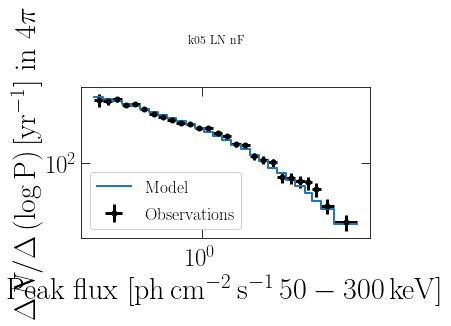

################################################
################# k1_LN_nF #####################
18:16:44.502 [INFO] Global GRB rate: 1137.9500015101319
18:16:44.531 [INFO]           Stern chi2: 2.3651e+01
18:16:44.532 [INFO]  Stern normalization: 3.6214e-03 yr-1
18:16:44.532 [INFO]  Simulation duration: 2.7614e+02 yr
18:16:44.533 [INFO]            ndot_LGRB: 3.6214e+03 LGRB/yr


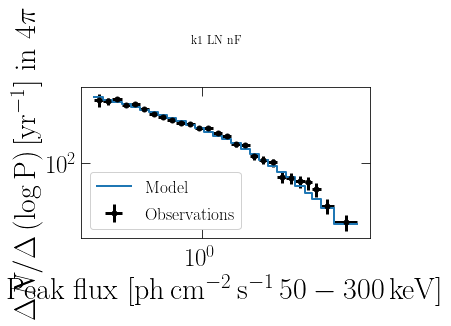

################################################
################# k2_LN_nF #####################
18:16:45.035 [INFO] Global GRB rate: 1137.9500015101319
18:16:45.081 [INFO]           Stern chi2: 2.5278e+01
18:16:45.081 [INFO]  Stern normalization: 2.1816e-03 yr-1
18:16:45.082 [INFO]  Simulation duration: 4.5838e+02 yr
18:16:45.082 [INFO]            ndot_LGRB: 2.1816e+03 LGRB/yr


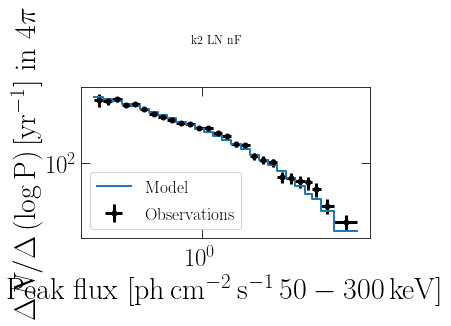

################################################
################# kF_A_nSFR #####################
18:16:45.505 [INFO] Global GRB rate: 1137.9500015101319
18:16:45.555 [INFO]           Stern chi2: 2.9176e+01
18:16:45.556 [INFO]  Stern normalization: 1.9441e-03 yr-1
18:16:45.557 [INFO]  Simulation duration: 5.1439e+02 yr
18:16:45.557 [INFO]            ndot_LGRB: 1.9441e+03 LGRB/yr


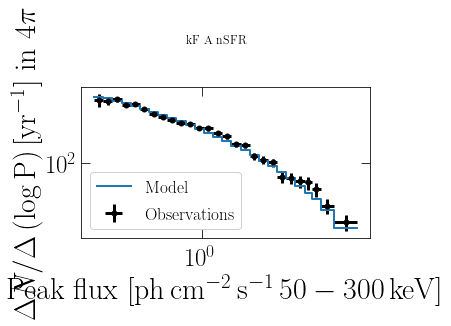

################################################
################# k0_A_nF #####################
18:16:45.980 [INFO] Global GRB rate: 1137.9500015101319
18:16:45.993 [INFO]           Stern chi2: 2.6448e+01
18:16:45.994 [INFO]  Stern normalization: 7.9890e-03 yr-1
18:16:45.995 [INFO]  Simulation duration: 1.2517e+02 yr
18:16:45.995 [INFO]            ndot_LGRB: 7.9890e+03 LGRB/yr


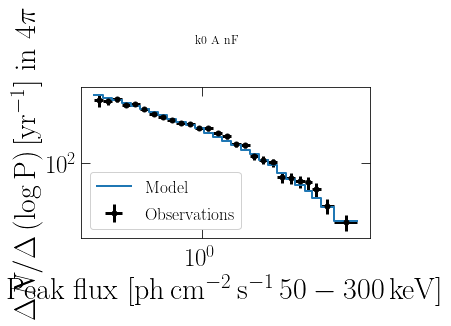

################################################
################# k05_A_nF #####################
18:16:46.337 [INFO] Global GRB rate: 1137.9500015101319
18:16:46.353 [INFO]           Stern chi2: 3.5543e+01
18:16:46.354 [INFO]  Stern normalization: 6.8070e-03 yr-1
18:16:46.355 [INFO]  Simulation duration: 1.4691e+02 yr
18:16:46.356 [INFO]            ndot_LGRB: 6.8070e+03 LGRB/yr


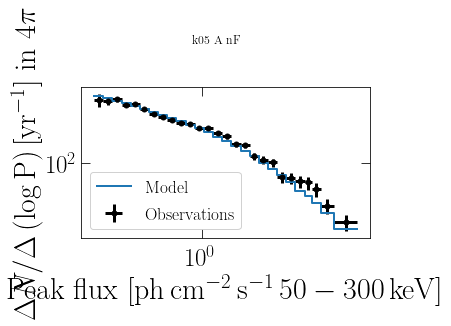

################################################
################# k05_A_nF_2 #####################
18:16:46.684 [INFO] Global GRB rate: 1137.9500015101319
18:16:46.705 [INFO]           Stern chi2: 2.9691e+01
18:16:46.706 [INFO]  Stern normalization: 4.9277e-03 yr-1
18:16:46.707 [INFO]  Simulation duration: 2.0294e+02 yr
18:16:46.707 [INFO]            ndot_LGRB: 4.9277e+03 LGRB/yr


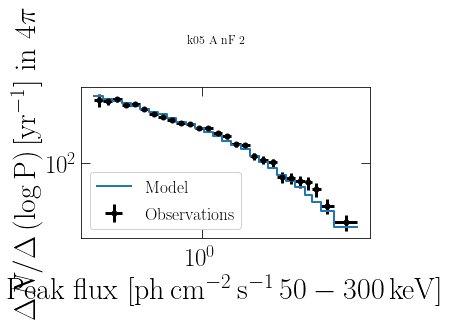

################################################
################# k1_A_nF #####################
18:16:47.102 [INFO] Global GRB rate: 1137.9500015101319
18:16:47.128 [INFO]           Stern chi2: 3.1828e+01
18:16:47.129 [INFO]  Stern normalization: 3.9625e-03 yr-1
18:16:47.130 [INFO]  Simulation duration: 2.5237e+02 yr
18:16:47.130 [INFO]            ndot_LGRB: 3.9625e+03 LGRB/yr


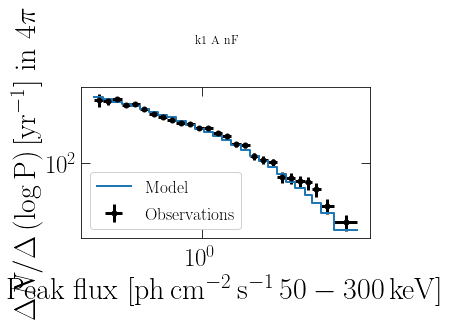

################################################
################# k1_A_nF_2 #####################
18:16:47.457 [INFO] Global GRB rate: 1137.9500015101319
18:16:47.479 [INFO]           Stern chi2: 2.4320e+01
18:16:47.480 [INFO]  Stern normalization: 4.7613e-03 yr-1
18:16:47.480 [INFO]  Simulation duration: 2.1003e+02 yr
18:16:47.481 [INFO]            ndot_LGRB: 4.7613e+03 LGRB/yr


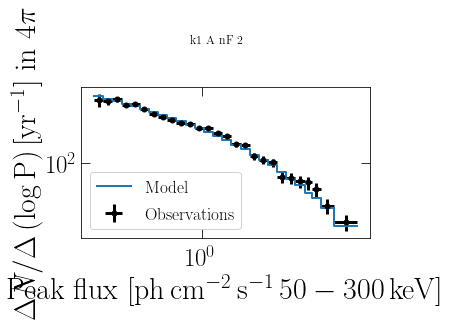

################################################
################# k2_A_nF #####################
18:16:47.869 [INFO] Global GRB rate: 1137.9500015101319
18:16:47.914 [INFO]           Stern chi2: 2.7315e+01
18:16:47.915 [INFO]  Stern normalization: 2.0414e-03 yr-1
18:16:47.915 [INFO]  Simulation duration: 4.8986e+02 yr
18:16:47.915 [INFO]            ndot_LGRB: 2.0414e+03 LGRB/yr


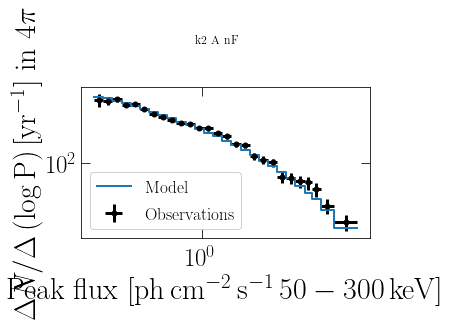

################################################


In [6]:
# Calculate the predicted rate for SVOM/ECLAIRs
sky_frac = ECLAIRs_prop['omega_ECLAIRs_tot'] / (4*np.pi)
for mod in model_names:
    print(f"################# {mod} #####################")
    norm_Stern, mod_Stern = obs.compare_to_Stern(dfs[mod][dfs[mod]['pdet_Stern']==1]['pht_pflx_BATSE'],
                                                 Stern_file=paths_to_dir['obs']/'Stern_lognlogp_rebinned.txt',
                                                 Nb_GRBs=Nb_GRBs, show_plot=True)
    fig = plt.gcf()
    fig.suptitle(mod.replace('_',' '))
    results[mod] = {}
    results[mod]['Tsim'] = 1./norm_Stern
    results[mod]['ndot_LGRB'] = norm_Stern * Nb_GRBs
    results[mod]['ECLAIRs_cts_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_pht_cts']) * norm_Stern * sky_frac
    results[mod]['ECLAIRs_flnc_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_pht_flnc']) * norm_Stern * sky_frac
    results[mod]['ECLAIRs_tot_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_tot']) * norm_Stern * sky_frac
    plt.show()
    print("################################################")
    
    

################# kF_LN_nSFR #####################
18:33:34.174 [INFO]           EpGBM chi2: 1.3630e+01
18:33:34.174 [INFO]  EpGBM normalization: 1.3185e-02


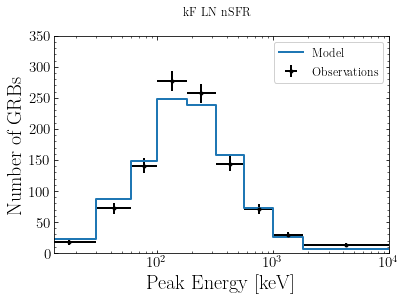

################################################
################# k0_LN_nF #####################
18:33:34.530 [INFO]           EpGBM chi2: 1.0703e+01
18:33:34.531 [INFO]  EpGBM normalization: 4.5920e-02


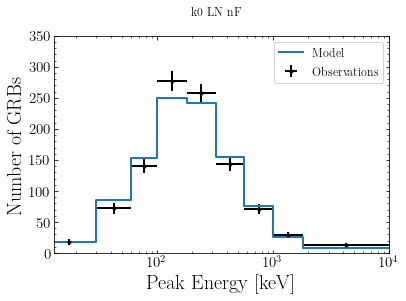

################################################
################# k05_LN_nF #####################
18:33:34.970 [INFO]           EpGBM chi2: 1.0159e+01
18:33:34.971 [INFO]  EpGBM normalization: 2.4445e-02


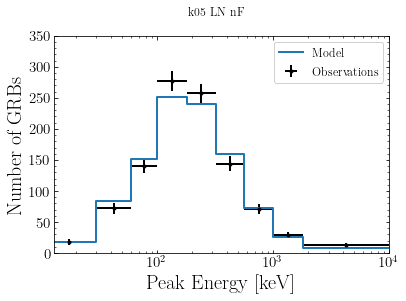

################################################
################# k1_LN_nF #####################
18:33:35.775 [INFO]           EpGBM chi2: 1.0937e+01
18:33:35.775 [INFO]  EpGBM normalization: 1.6747e-02


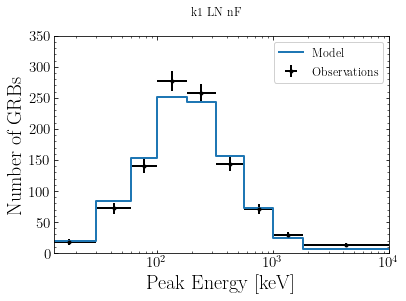

################################################
################# k2_LN_nF #####################
18:33:36.183 [INFO]           EpGBM chi2: 1.2894e+01
18:33:36.184 [INFO]  EpGBM normalization: 1.0388e-02


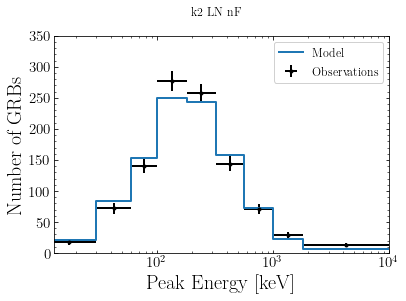

################################################
################# kF_A_nSFR #####################
18:33:36.638 [INFO]           EpGBM chi2: 1.0089e+01
18:33:36.638 [INFO]  EpGBM normalization: 9.4789e-03


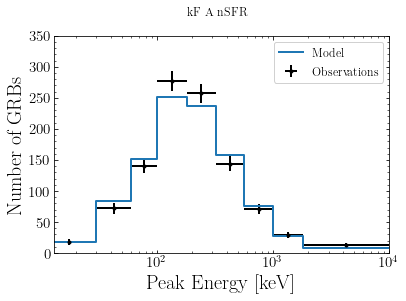

################################################
################# k0_A_nF #####################
18:33:37.012 [INFO]           EpGBM chi2: 1.1923e+01
18:33:37.012 [INFO]  EpGBM normalization: 3.8317e-02


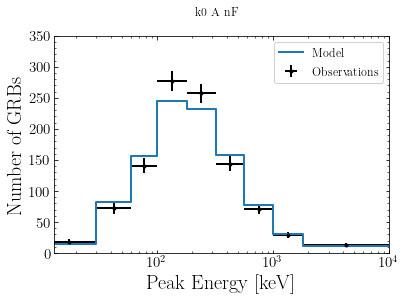

################################################
################# k05_A_nF #####################
18:33:37.376 [INFO]           EpGBM chi2: 2.0971e+01
18:33:37.377 [INFO]  EpGBM normalization: 3.3601e-02


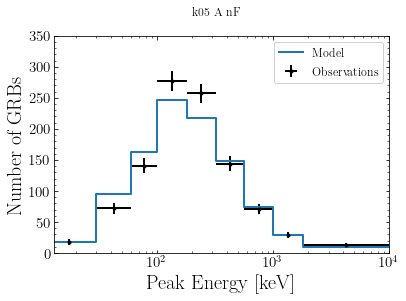

################################################
################# k05_A_nF_2 #####################
18:33:37.741 [INFO]           EpGBM chi2: 1.0145e+01
18:33:37.742 [INFO]  EpGBM normalization: 2.4043e-02


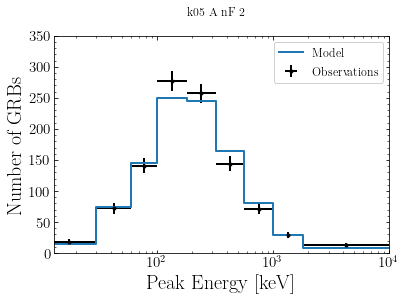

################################################
################# k1_A_nF #####################
18:33:38.392 [INFO]           EpGBM chi2: 1.3124e+01
18:33:38.392 [INFO]  EpGBM normalization: 1.9353e-02


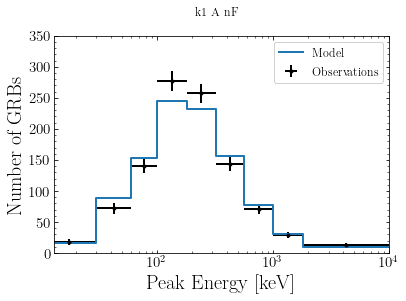

################################################
################# k1_A_nF_2 #####################
18:33:38.998 [INFO]           EpGBM chi2: 1.0925e+01
18:33:38.999 [INFO]  EpGBM normalization: 2.2610e-02


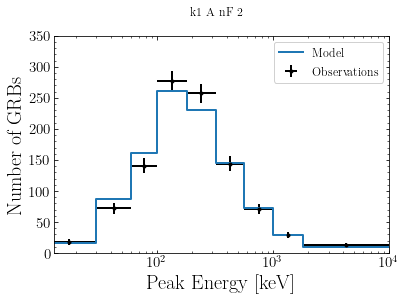

################################################
################# k2_A_nF #####################
18:33:39.420 [INFO]           EpGBM chi2: 1.1694e+01
18:33:39.420 [INFO]  EpGBM normalization: 9.8793e-03


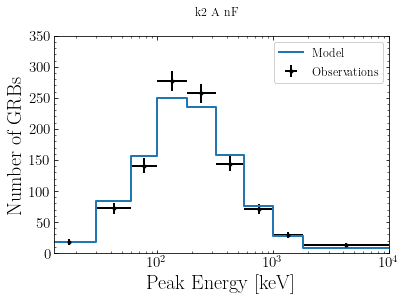

################################################


In [71]:
for mod in model_names:
    print(f"################# {mod} #####################")
    chi2_EpGBM = obs.compare_to_EpGBM(dfs[mod][dfs[mod]['pdet_EpGBM']==1]['Epobs'],
                                      GBM_file=paths_to_dir['obs']/'Ep_GBM_for_plotting.txt',
                                      show_plot=True)
    fig = plt.gcf()
    fig.suptitle(mod.replace('_',' '))
    plt.show()
    print("################################################")
    
    

In [7]:
df_res = pd.DataFrame(results)
df_res

,kF_LN_nSFR,k0_LN_nF,k05_LN_nF,k1_LN_nF,k2_LN_nF,kF_A_nSFR,k0_A_nF,k05_A_nF,k05_A_nF_2,k1_A_nF,k1_A_nF_2,k2_A_nF
Tsim,359.568006,107.543562,195.736184,276.136094,458.375568,514.390049,125.171463,146.906548,202.935130,252.366898,210.028491,489.864401
ndot_LGRB,2781.115073,9298.557529,5108.917418,3621.402710,2181.617149,1944.050048,7989.041426,6807.048523,4927.683051,3962.484818,4761.258806,2041.381241
ECLAIRs_cts_rate,35.517810,36.228037,36.465145,36.265496,35.268898,39.448614,40.561184,47.259723,36.176311,42.077189,49.488399,39.466683
ECLAIRs_flnc_rate,48.786413,50.544171,50.418474,49.460891,48.559040,56.228962,58.588569,71.399722,51.105760,61.299427,74.819796,56.117060
ECLAIRs_tot_rate,50.354023,52.179278,52.037610,51.054372,50.111609,58.118457,60.550336,73.874929,52.817480,63.412562,77.448581,58.007204


################# k0_LN_nF #####################


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


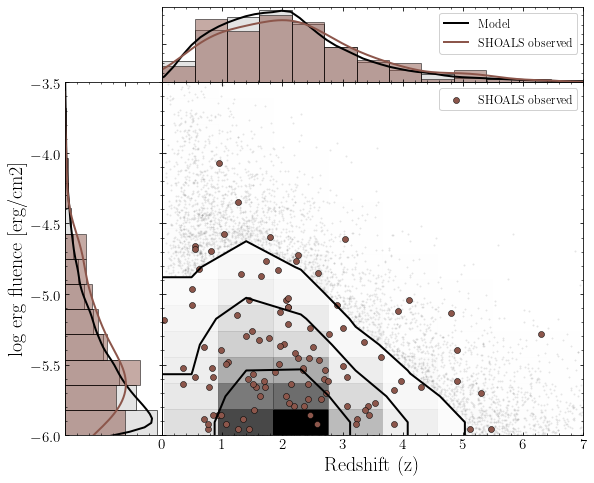

################################################
################# k2_LN_nF #####################


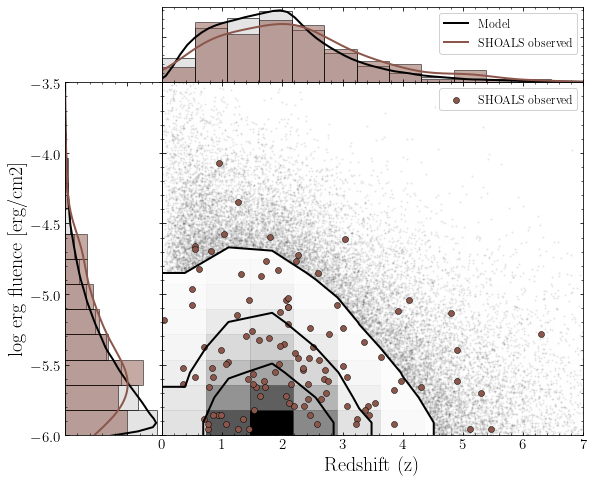

################################################
################# k0_A_nF #####################


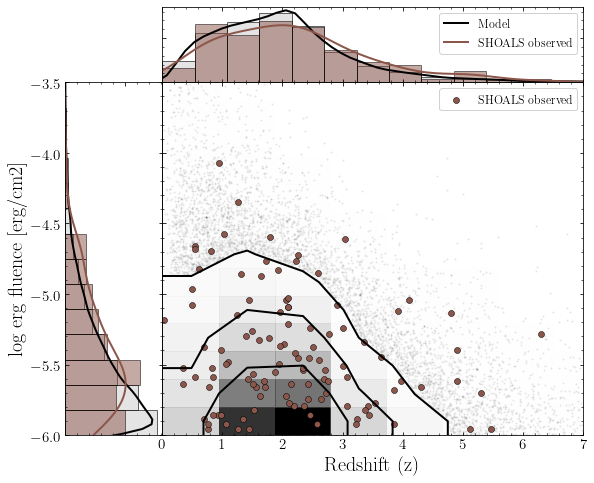

################################################
################# k2_A_nF #####################


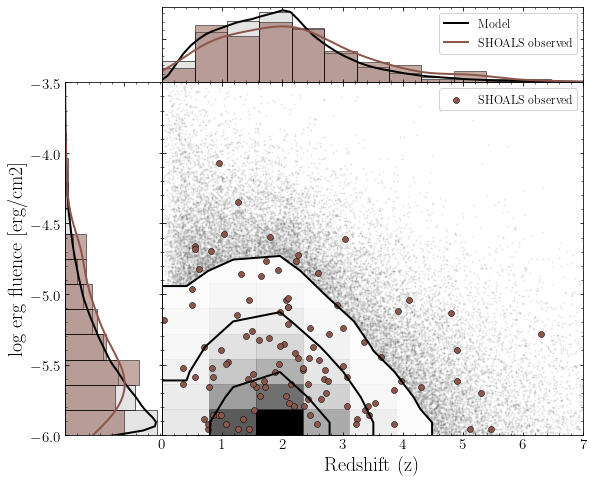

################################################


In [8]:
# This is not very interesting
for mod in model_names_ks:
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_flnc_z_plane(dfs[mod][dfs[mod]['pdet_SHOALS']==1])
    plt.show()
    print("################################################")

################# k0_LN_nF #####################
D-stat, p_value = 0.077, 0.523
################# k2_LN_nF #####################
D-stat, p_value = 0.058, 0.853
################# k0_A_nF #####################
D-stat, p_value = 0.057, 0.865
################# k2_A_nF #####################
D-stat, p_value = 0.049, 0.950


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if fig.canvas is None:


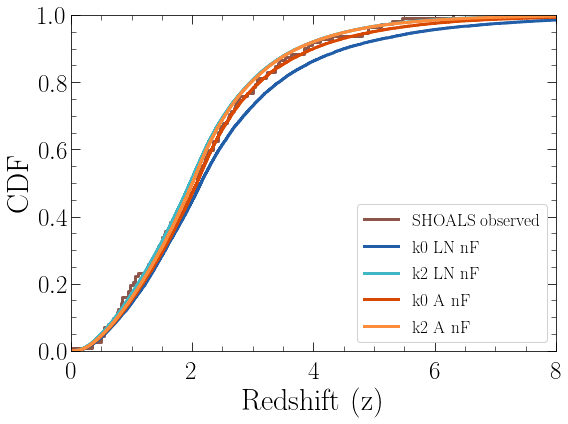

In [29]:
# Plot the redshift distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these redshift distributions and the observed SHOALS redshift distribution
fig, ax = plt.subplots(figsize=(8,6))
df_obs = io.read_SHOALS_file()
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    pf.plot_SHOALS_distr(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=(i==0),
                          cumul=True,
                          ax=ax,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'], df_obs['z'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))
ax.set_xlabel('Redshift (z)')
ax.set_xlim(0,8)
# plt.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr.pdf')
plt.show()

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if fig.canvas is None:


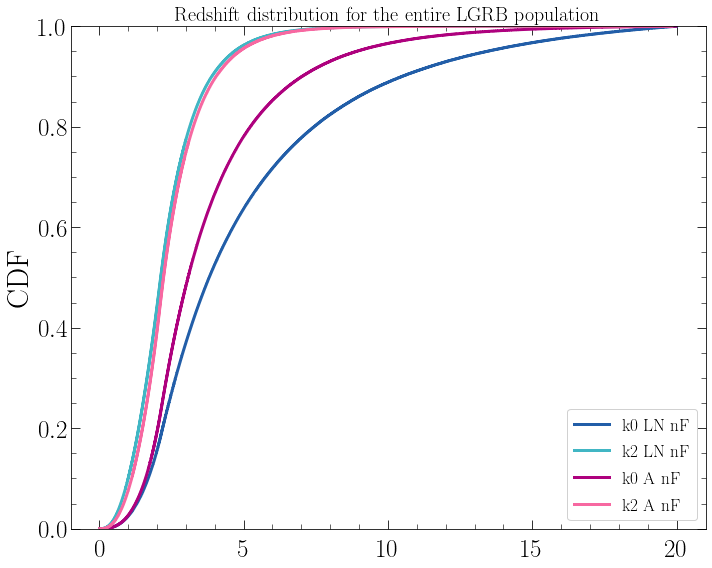

In [31]:
# Since all the redshift distribution of SHOALS look the same, I looked at the redshift distribution
# of the whole LGRB population, which is plotted below
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Redshift distribution for the entire LGRB population', **{'size':20})
# colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    pf.plot_SHOALS_distr(dfs[mod]['z'], key='z', plot_obs=False,
                            cumul=True, ax=ax, mod_color=colors[i], mod_label=mod.replace('_',' '))

12:20:04.274 [INFO] Subsampling done in 1.164 s
12:20:23.854 [INFO] KS calculations done in 19.579 s
12:20:35.096 [INFO] CDF calculation done in 11.241 s


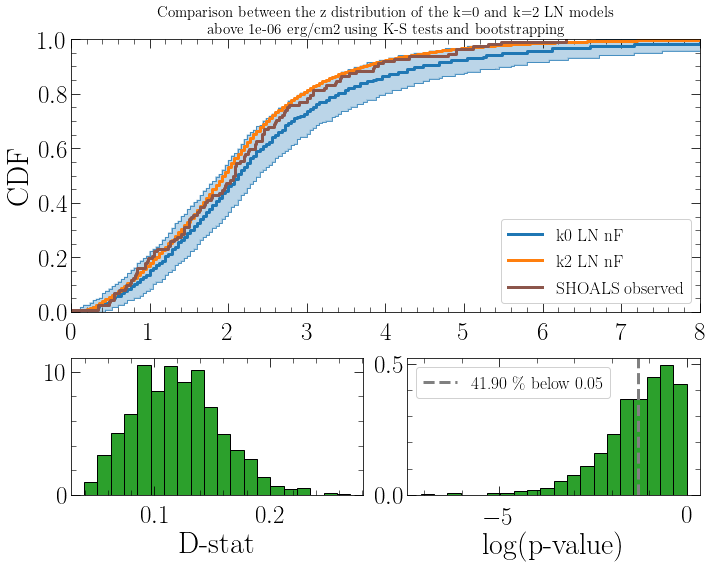

In [36]:
# Clearly the sample size and fluence cut of SHOALS don't allow us to discriminate between k=0 and k=2 models
# What fluence cut and sample size is needed to discriminate between k=0 and k=2 models?
# To answer this we create subsamples of size N_SHOALS=117 from the k=0 redshift distribution and compute
# the K-S test between these subsamples and the entire k=2 sample.
# This is repeated N_bs times (bs stands for bootstrap) to get an idea of how robust the results are.
# For each subsample we compute the K-S test and obtain the D-statistic and the p-value for that realization.
# The resulting distributions of D-statistics and p-values and shown in the bottom panels of the figure
# The top panel shows the CDF and the confidence bounds around it are calculated from the bootstrapping as well.
# The fraction of bootstrap samples that have p-value below 0.05 is shown in the legend of the bottom right panel
N_bs = 1000
N_sub = 117
thrsh = 1e-6
precision=500
st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample2=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
df_SHOALS = io.read_SHOALS_file()
z_SHOALS = df_SHOALS['z'].to_numpy()
x_obs, cdf_obs = st.unbinned_empirical_cdf(z_SHOALS)
axes[0].plot(x_obs, cdf_obs, color='C5', drawstyle='steps-post', label='SHOALS observed', lw=3)

axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
                  {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:28:04.264 [INFO] Subsampling done in 2.672 s
17:28:07.480 [INFO] KS calculations done in 3.215 s
17:28:09.534 [INFO] CDF calculation done in 2.054 s


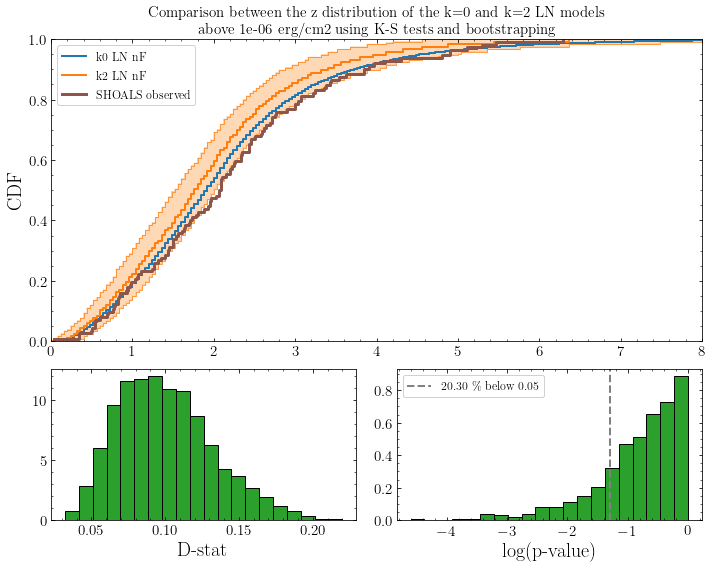

In [12]:
# The following is to show that the results don't change if we subsample from the k=2 scenario instead
# and compare with the entire k=0 redshift distribution.
st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:29:23.104 [INFO] Subsampling done in 14.481 s
17:29:45.986 [INFO] KS calculations done in 22.882 s
17:29:59.928 [INFO] CDF calculation done in 13.941 s


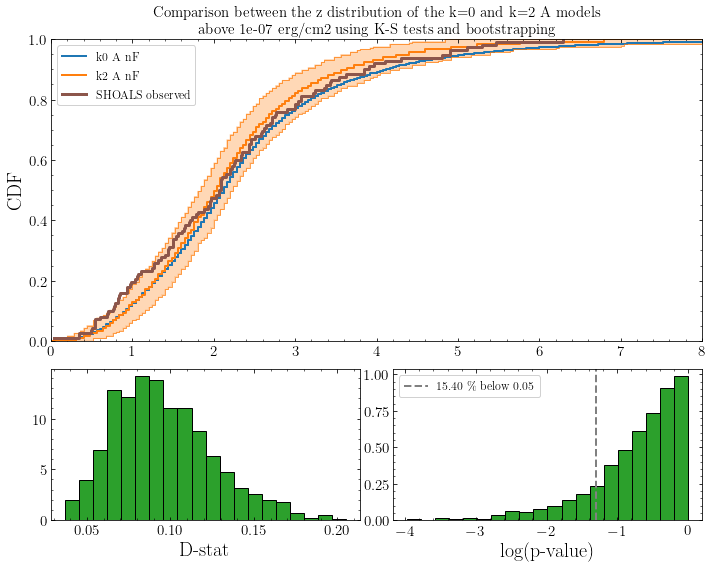

In [14]:
# Here we do the same thing but with the Amati-like scenarios
N_bs = 1000
N_sub = 117
thrsh = 1e-7
precision=500
st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:31:14.635 [INFO] Subsampling done in 30.914 s
17:32:16.941 [INFO] KS calculations done in 62.305 s
17:33:00.156 [INFO] CDF calculation done in 43.215 s


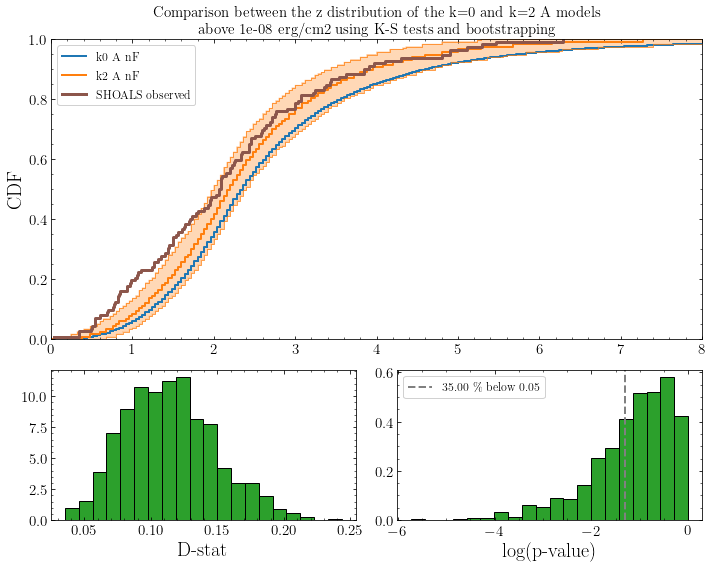

In [16]:
# It seems it is much harder to discriminate between the k=0 and k=2 models, even at deep fluence cuts for the
# Amati-like scenarios
thrsh = 1e-8
st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

In [37]:
# Now we want to explore the fluence cut vs sample size plane and see what is required to discriminate
# between k=0 and k=2. We create two arrays for the fluence cuts and the sample size we reasonably expect
# can be obtained and compute the fraction of bootstrap samples that have a p-value below 0.05
# We associate this fraction with the probability of discriminating between the k=0 and k=2 scenarios at the
# 95% confidence level.
flnc_cuts = np.array([1.8e-6, 1e-6, 5.6e-7, 3.2e-7, 1.8e-7, 1e-7, 5.7e-8])
size = np.array([56, 100, 178, 316, 562, 1000, 1780])
p_discr_z = {}
p_discr_L = {}
if load_files:
    for mod in ['LN','LN2','A','A2']:
        try:
            p_discr_z[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}').to_numpy()
            p_discr_L[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_L_{mod}').to_numpy()
        except Exception:
            pass

In [38]:
# WARNING: long computing time (at least 10 min)
# This is for the LogNormal models
precision=500
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f}% Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN'] = frac

12:21:44.208 [INFO] 0.0% Size, fluence cut = 56 1.8e-06
12:21:45.943 [INFO] Subsampling done in 1.684 s
12:21:48.151 [INFO] KS calculations done in 2.207 s
12:21:49.523 [INFO] CDF calculation done in 1.372 s
12:21:49.533 [INFO] Fraction of samples different at the 95% confidence level : 0.07
12:21:49.533 [INFO] 2.0408163265306123% Size, fluence cut = 56 1e-06
12:21:51.678 [INFO] Subsampling done in 2.081 s
12:21:55.101 [INFO] KS calculations done in 3.423 s
12:21:57.380 [INFO] CDF calculation done in 2.278 s
12:21:57.400 [INFO] Fraction of samples different at the 95% confidence level : 0.194
12:21:57.400 [INFO] 4.081632653061225% Size, fluence cut = 56 5.6e-07
12:22:01.151 [INFO] Subsampling done in 3.679 s
12:22:07.109 [INFO] KS calculations done in 5.958 s
12:22:10.625 [INFO] CDF calculation done in 3.515 s
12:22:10.655 [INFO] Fraction of samples different at the 95% confidence level : 0.391
12:22:10.655 [INFO] 6.122448979591836% Size, fluence cut = 56 3.2e-07
12:22:16.580 [INFO] Su

12:33:25.075 [INFO] CDF calculation done in 12.291 s
12:33:25.152 [INFO] Fraction of samples different at the 95% confidence level : 1.0
12:33:25.153 [INFO] 55.10204081632653% Size, fluence cut = 316 5.7e-08
12:33:36.628 [INFO] Subsampling done in 11.390 s
12:34:04.791 [INFO] KS calculations done in 28.162 s
12:34:21.593 [INFO] CDF calculation done in 16.802 s
12:34:21.691 [INFO] Fraction of samples different at the 95% confidence level : 1.0
12:34:21.692 [INFO] 57.142857142857146% Size, fluence cut = 562 1.8e-06
12:34:23.057 [INFO] Subsampling done in 1.334 s
12:34:25.271 [INFO] KS calculations done in 2.213 s
12:34:26.585 [INFO] CDF calculation done in 1.314 s
12:34:26.594 [INFO] Fraction of samples different at the 95% confidence level : 0.427
12:34:26.595 [INFO] 59.183673469387756% Size, fluence cut = 562 1e-06
12:34:28.685 [INFO] Subsampling done in 2.052 s
12:34:32.330 [INFO] KS calculations done in 3.645 s
12:34:34.397 [INFO] CDF calculation done in 2.066 s
12:34:34.416 [INFO] F

In [39]:
# WARNING: long computing time (at least 10 min)
# This is to check that results don't depend on whether we're subsampling from k=0 or k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN2'] = frac

12:44:03.825 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
12:44:04.613 [INFO] Subsampling done in 0.748 s
12:44:15.968 [INFO] KS calculations done in 11.355 s
12:44:23.100 [INFO] CDF calculation done in 7.131 s
12:44:23.136 [INFO] Fraction of samples different at the 95% confidence level : 0.086
12:44:23.137 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
12:44:24.341 [INFO] Subsampling done in 1.143 s
12:44:43.717 [INFO] KS calculations done in 19.376 s
12:44:55.229 [INFO] CDF calculation done in 11.511 s
12:44:55.286 [INFO] Fraction of samples different at the 95% confidence level : 0.206
12:44:55.286 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
12:44:56.867 [INFO] Subsampling done in 1.518 s
12:45:26.001 [INFO] KS calculations done in 29.133 s
12:45:42.652 [INFO] CDF calculation done in 16.651 s
12:45:42.724 [INFO] Fraction of samples different at the 95% confidence level : 0.403
12:45:42.725 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
12:45:44.906 [INFO] Subsampling done in 2.120 s
12:

13:20:24.535 [INFO] CDF calculation done in 54.922 s
13:20:24.812 [INFO] Fraction of samples different at the 95% confidence level : 1.0
13:20:24.813 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
13:20:25.495 [INFO] Subsampling done in 0.650 s
13:20:36.764 [INFO] KS calculations done in 11.268 s
13:20:43.152 [INFO] CDF calculation done in 6.388 s
13:20:43.178 [INFO] Fraction of samples different at the 95% confidence level : 0.456
13:20:43.179 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
13:20:44.181 [INFO] Subsampling done in 0.963 s
13:21:02.501 [INFO] KS calculations done in 18.320 s
13:21:13.458 [INFO] CDF calculation done in 10.956 s
13:21:13.502 [INFO] Fraction of samples different at the 95% confidence level : 0.986
13:21:13.503 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
13:21:15.058 [INFO] Subsampling done in 1.508 s
13:21:43.397 [INFO] KS calculations done in 28.338 s
13:21:59.995 [INFO] CDF calculation done in 16.598 s
13:22:00.061 [INFO] Fraction of samples different at

In [40]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A2'] = frac

13:47:57.569 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
13:47:59.111 [INFO] Subsampling done in 1.454 s
13:48:01.553 [INFO] KS calculations done in 2.441 s
13:48:03.115 [INFO] CDF calculation done in 1.561 s
13:48:03.128 [INFO] Fraction of samples different at the 95% confidence level : 0.049
13:48:03.129 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
13:48:05.335 [INFO] Subsampling done in 2.165 s
13:48:09.219 [INFO] KS calculations done in 3.884 s
13:48:11.610 [INFO] CDF calculation done in 2.390 s
13:48:11.629 [INFO] Fraction of samples different at the 95% confidence level : 0.066
13:48:11.630 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
13:48:15.322 [INFO] Subsampling done in 3.640 s
13:48:23.113 [INFO] KS calculations done in 7.790 s
13:48:27.729 [INFO] CDF calculation done in 4.615 s
13:48:27.757 [INFO] Fraction of samples different at the 95% confidence level : 0.086
13:48:27.758 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
13:48:32.983 [INFO] Subsampling done in 5.164 s
13:48:44

14:02:17.289 [INFO] CDF calculation done in 20.187 s
14:02:17.388 [INFO] Fraction of samples different at the 95% confidence level : 0.734
14:02:17.389 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
14:02:18.840 [INFO] Subsampling done in 1.417 s
14:02:21.419 [INFO] KS calculations done in 2.578 s
14:02:22.954 [INFO] CDF calculation done in 1.534 s
14:02:22.971 [INFO] Fraction of samples different at the 95% confidence level : 0.07
14:02:22.972 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
14:02:25.153 [INFO] Subsampling done in 2.140 s
14:02:29.414 [INFO] KS calculations done in 4.260 s
14:02:31.923 [INFO] CDF calculation done in 2.509 s
14:02:31.942 [INFO] Fraction of samples different at the 95% confidence level : 0.316
14:02:31.943 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
14:02:35.395 [INFO] Subsampling done in 3.403 s
14:02:42.536 [INFO] KS calculations done in 7.141 s
14:02:47.878 [INFO] CDF calculation done in 5.341 s
14:02:47.911 [INFO] Fraction of samples different at the

In [41]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios subsampling from k=0 instead of k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{:.1f} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A'] = frac

14:13:25.265 [INFO] 0.0 %. Size, fluence cut = 56 1.8e-06
14:13:26.051 [INFO] Subsampling done in 0.753 s
14:13:37.392 [INFO] KS calculations done in 11.340 s
14:13:44.358 [INFO] CDF calculation done in 6.965 s
14:13:44.386 [INFO] Fraction of samples different at the 95% confidence level : 0.048
14:13:44.387 [INFO] 2.0 %. Size, fluence cut = 56 1e-06
14:13:45.543 [INFO] Subsampling done in 1.115 s
14:14:05.660 [INFO] KS calculations done in 20.116 s
14:14:17.924 [INFO] CDF calculation done in 12.264 s
14:14:17.979 [INFO] Fraction of samples different at the 95% confidence level : 0.058
14:14:17.980 [INFO] 4.1 %. Size, fluence cut = 56 5.6e-07
14:14:19.757 [INFO] Subsampling done in 1.725 s
14:14:51.103 [INFO] KS calculations done in 31.346 s
14:15:09.855 [INFO] CDF calculation done in 18.751 s
14:15:09.977 [INFO] Fraction of samples different at the 95% confidence level : 0.108
14:15:09.978 [INFO] 6.1 %. Size, fluence cut = 56 3.2e-07
14:15:13.111 [INFO] Subsampling done in 3.036 s
14:

14:54:10.879 [INFO] CDF calculation done in 63.015 s
14:54:11.195 [INFO] Fraction of samples different at the 95% confidence level : 0.713
14:54:11.196 [INFO] 57.1 %. Size, fluence cut = 562 1.8e-06
14:54:11.975 [INFO] Subsampling done in 0.747 s
14:54:24.311 [INFO] KS calculations done in 12.336 s
14:54:31.511 [INFO] CDF calculation done in 7.199 s
14:54:31.543 [INFO] Fraction of samples different at the 95% confidence level : 0.064
14:54:31.544 [INFO] 59.2 %. Size, fluence cut = 562 1e-06
14:54:32.714 [INFO] Subsampling done in 1.128 s
14:54:54.971 [INFO] KS calculations done in 22.256 s
14:55:07.716 [INFO] CDF calculation done in 12.744 s
14:55:07.767 [INFO] Fraction of samples different at the 95% confidence level : 0.292
14:55:07.768 [INFO] 61.2 %. Size, fluence cut = 562 5.6e-07
14:55:09.763 [INFO] Subsampling done in 1.943 s
14:55:43.057 [INFO] KS calculations done in 33.294 s
14:56:02.078 [INFO] CDF calculation done in 19.021 s
14:56:02.162 [INFO] Fraction of samples different 

In [42]:
def plot_fluence_cut_vs_sample_size(size, flnc_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_flnc_cuts_2D = np.meshgrid(np.log10(size), np.log10(flnc_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_flnc_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(flnc_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(flnc_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(flnc_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Fluence cut [erg/cm$^2$]")
    return

LN


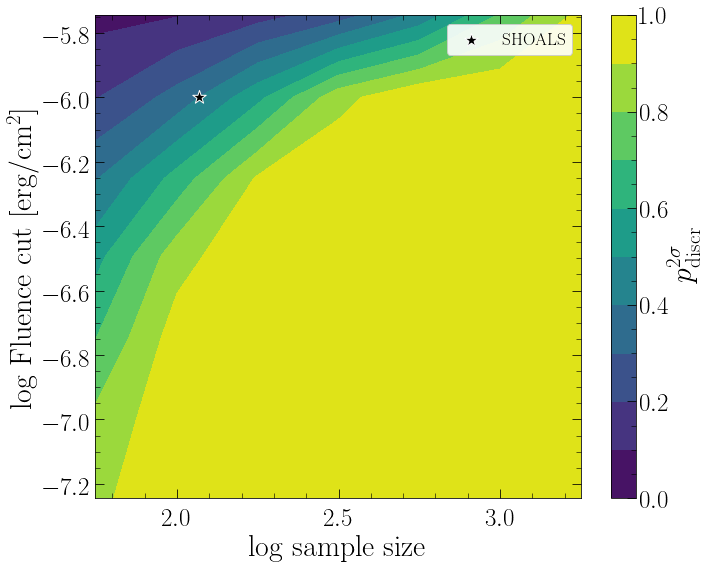

LN2


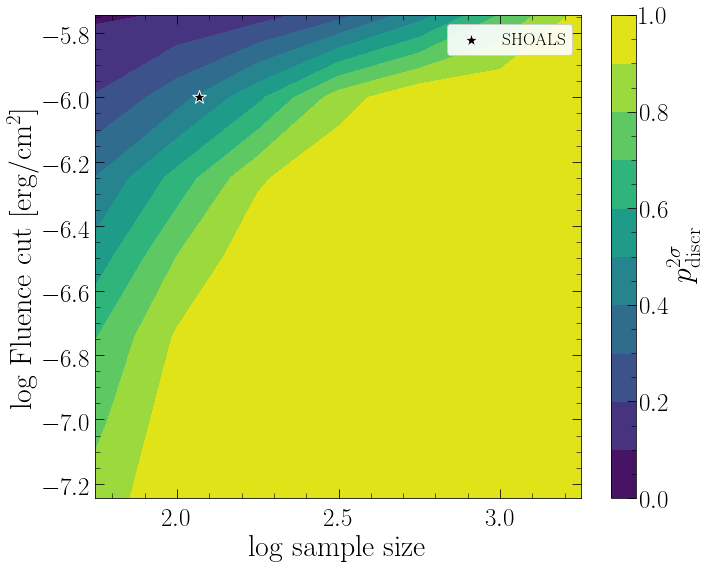

A2


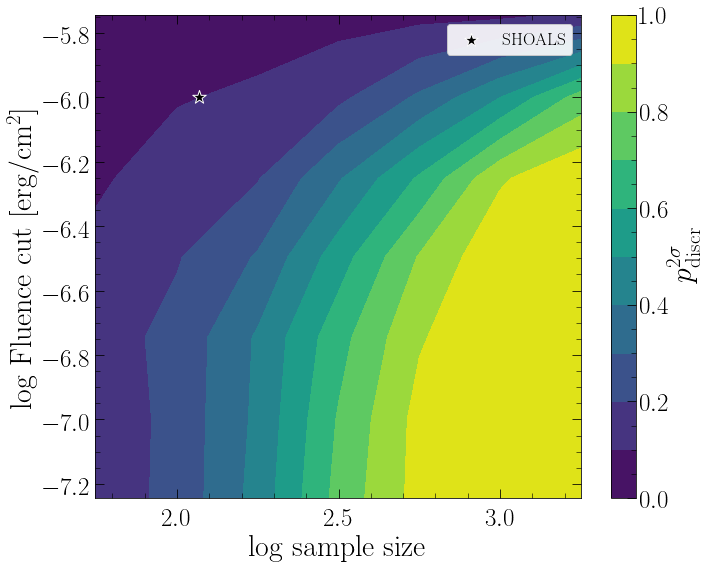

A


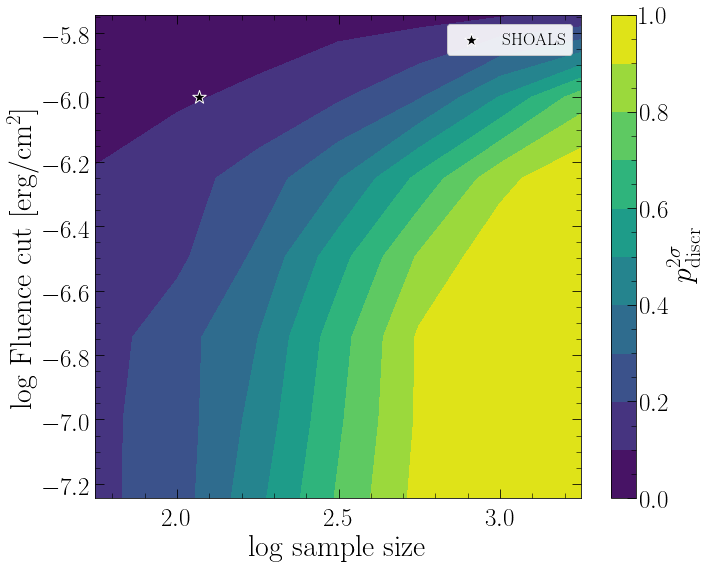

In [45]:
# Create the 2D plane 'fluence cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
for key, value in p_discr_z.items():
    print(key)
    plot_fluence_cut_vs_sample_size(size, flnc_cuts, value)
    ax = plt.gca()
    ax.scatter(np.log10(117), -6, s=200, marker='*', edgecolor='w', color='k', label='SHOALS')
    ax.legend(loc='best')
    plt.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/flnc_sampsize_{key}.pdf')
    plt.show()

In [44]:
# Turn the data into DataFrames and save them
if not load_files:
    for mod, frac in p_discr_z.items():
        df_temp = pd.DataFrame(data=frac, index=size.astype(str), columns=flnc_cuts.astype(str))
        df_temp.to_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}')


In [22]:
# Same thing but with the eBAT6 sample
pflx_cuts = np.logspace(np.log10(0.05), np.log10(3), 5)
size = np.array([56, 100, 178, 316, 562, 1000, 1780])
p_discr_z_BAT6 = {}
load_files=False
if load_files:
    for mod in ['LN','A']:
        try:
            p_discr_z_BAT6[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_z_BAT6{mod}').to_numpy()
        except Exception:
            pass

In [27]:
import time
from stats import *

def subsample_and_KS(df1, df2, N_sub, key, confidence=95.0, N_bs=100, precision=500, bins=None, create_CDF=True,
    show_plot=False, label1=None, label2=None, subsample1=True, subsample2=True, color1=None, color2=None):
    """
        Compute the K-S test between a subsample of size N_sub.
        Repeat the K-S test for N_bs bootstraps and create a distribution of p-values.
    """
    t1 = time.time()
    if subsample1:
        subsamp1 = subsample_with_bootstrap(df1, key=key, N_sub=N_sub, N_bs=N_bs)
    else:
        subsamp1 = df1[key].to_numpy()[:,np.newaxis] * np.ones(N_bs)
        subsamp1 = subsamp1.T
    if subsample2:
        subsamp2 = subsample_with_bootstrap(df2, key=key, N_sub=N_sub, N_bs=N_bs)
    else:
        subsamp2 = df2[key].to_numpy()[:,np.newaxis] * np.ones(N_bs)
        subsamp2 = subsamp2.T
    t2 = time.time()
    log.info(f"Subsampling done in {t2-t1:.3f} s")

    t1 = time.time()
    D_stat, p_value = compute_KS_with_bootstrap(subsamp1, subsamp2, N_bs)
    t2 = time.time()
    log.info(f"KS calculations done in {t2-t1:.3f} s")

    if create_CDF:
        t1 = time.time()
        CDF1 = CDF_with_bootstrap(subsamp1, bins=bins)
        CDF2 = CDF_with_bootstrap(subsamp2, bins=bins)
        med1, lw1, up1 = compute_CDF_quantiles(CDF1, confidence=confidence)
        med2, lw2, up2 = compute_CDF_quantiles(CDF2, confidence=confidence)
        t2 = time.time()
        log.info(f"CDF calculation done in {t2-t1:.3f} s")

    pfrac = len(p_value[np.where(p_value < (1.-confidence/100.))[0]])/len(p_value)

    if show_plot:
        pf.plot_CDFs_and_KS_results(bins=bins, med1=med1, med2=med2, lw1=lw1, lw2=lw2, up1=up1, up2=up2,
                                    D_stat=D_stat,
                                    p_value=p_value,
                                    confidence=confidence,
                                    pfrac=pfrac,
                                    label1=label1,
                                    label2=label2,
                                    color1=color1,
                                    color2=color2)

    return pfrac

10:55:40.210 [INFO] Subsampling done in 63.544 s
10:57:53.369 [INFO] KS calculations done in 133.159 s
10:59:10.945 [INFO] CDF calculation done in 77.575 s
10:59:10.994 [WARNING] No handles with labels found to put in legend.
10:59:11.001 [WARNING] No handles with labels found to put in legend.


(0, 10)

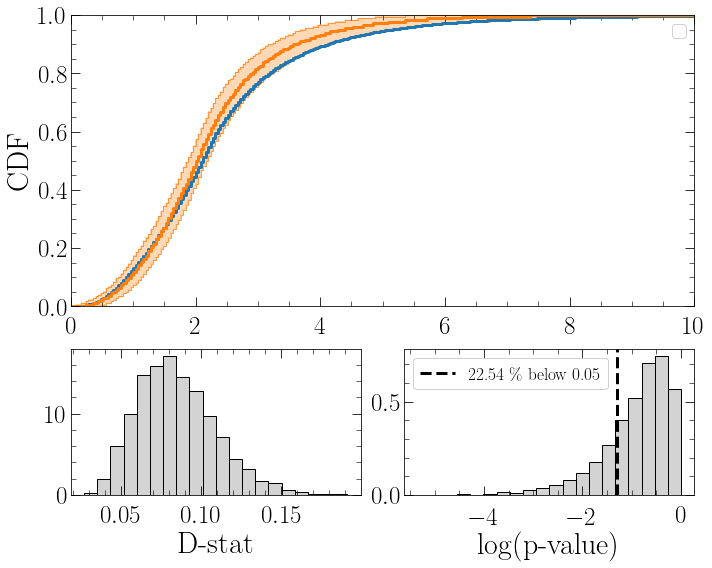

In [39]:
subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['pht_pflx_BAT']>=0.14)],
                             dfs['k2_A_nF'][(dfs['k2_A_nF']['pht_pflx_BAT']>=0.14)],
                             key='z', create_CDF=True, show_plot=True,
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=178,
                             N_bs=5000,
                             subsample1=False)
plt.gcf().axes[0].set_xlim(0,10)

10:50:28.651 [INFO] Subsampling done in 29.729 s
10:51:34.859 [INFO] KS calculations done in 66.207 s
10:52:14.465 [INFO] CDF calculation done in 39.605 s
10:52:14.512 [WARNING] No handles with labels found to put in legend.
10:52:14.630 [WARNING] No handles with labels found to put in legend.


(0, 10)

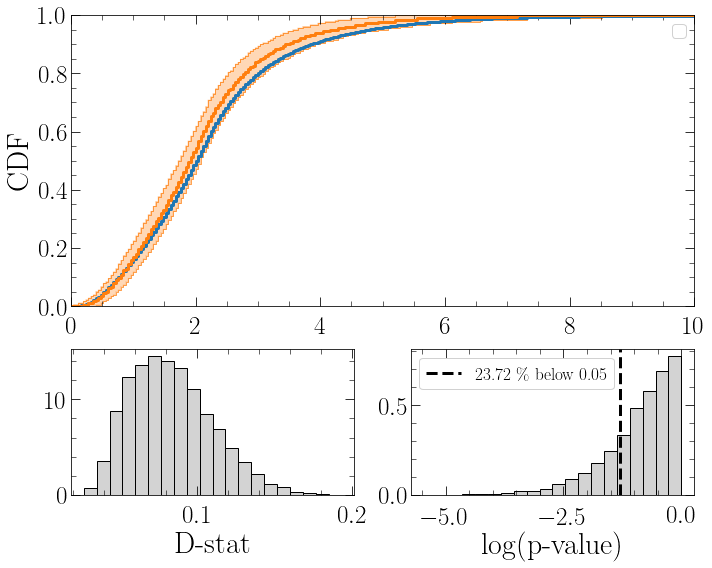

In [37]:
subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['pht_pflx_BAT']>=0.387)],
                             dfs['k2_A_nF'][(dfs['k2_A_nF']['pht_pflx_BAT']>=0.387)],
                             key='z', create_CDF=True, show_plot=True,
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=178,
                             N_bs=5000,
                             subsample1=False)
plt.gcf().axes[0].set_xlim(0,10)

In [23]:
precision=500
if not load_files:
    for mod in ['A']:
        frac = np.zeros((len(size), len(pflx_cuts)))
        k=0
        for i, j in product(range(len(size)), range(len(pflx_cuts))):
            log.info("{:.1f}% Size, pflx cut = {} {}".format(100*k/(len(size)*len(pflx_cuts)), size[i], pflx_cuts[j]))
            frac[i,j]= st.subsample_and_KS(dfs[f'k0_{mod}_nF'][(dfs[f'k0_{mod}_nF']['pht_pflx_BAT']>=pflx_cuts[j])],
                             dfs[f'k2_{mod}_nF'][(dfs[f'k2_{mod}_nF']['pht_pflx_BAT']>=pflx_cuts[j])],
                             key='z',
                             precision=precision,
                             bins=np.linspace(0,20,precision+1),
                             N_sub=size[i],
                             N_bs=1000,
                             subsample1=False)
            log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
            k+=1
        p_discr_z_BAT6[mod] = frac


10:25:09.316 [INFO] 0.0% Size, pflx cut = 56 0.049999999999999996
10:25:31.125 [INFO] Subsampling done in 21.542 s
10:26:15.677 [INFO] KS calculations done in 44.551 s
10:26:42.290 [INFO] CDF calculation done in 26.612 s
10:26:42.443 [INFO] Fraction of samples different at the 95% confidence level : 0.047
10:26:42.444 [INFO] 2.9% Size, pflx cut = 56 0.13915788418568703
10:26:53.892 [INFO] Subsampling done in 11.343 s
10:27:18.511 [INFO] KS calculations done in 24.618 s
10:27:33.326 [INFO] CDF calculation done in 14.815 s
10:27:33.409 [INFO] Fraction of samples different at the 95% confidence level : 0.068
10:27:33.410 [INFO] 5.7% Size, pflx cut = 56 0.38729833462074165
10:27:40.002 [INFO] Subsampling done in 6.514 s
10:27:51.706 [INFO] KS calculations done in 11.704 s
10:27:58.941 [INFO] CDF calculation done in 7.234 s
10:27:58.982 [INFO] Fraction of samples different at the 95% confidence level : 0.11
10:27:58.983 [INFO] 8.6% Size, pflx cut = 56 1.0779123358892524
10:28:01.605 [INFO] 

KeyboardInterrupt: 

In [17]:
for mod, frac in p_discr_z_BAT6.items():
        df_temp = pd.DataFrame(data=frac, index=size.astype(str), columns=pflx_cuts.astype(str))
        df_temp.to_parquet(f'/Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations/p_discr_z_BAT6_{mod}')
        

LN


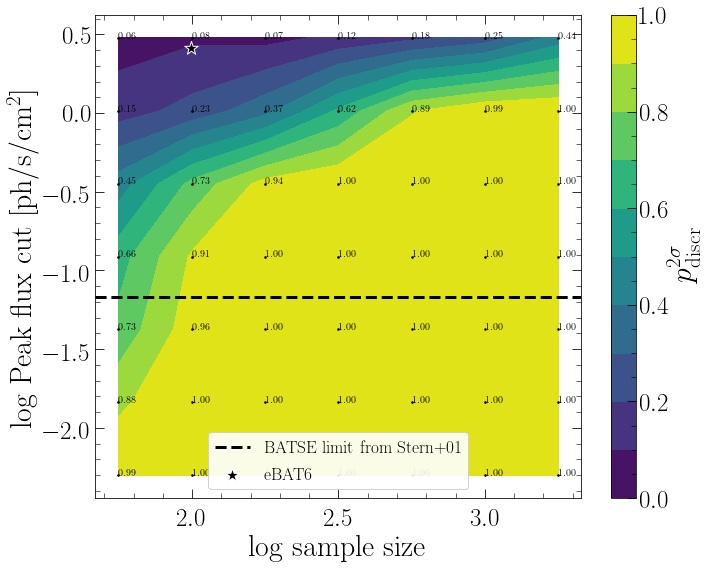

A


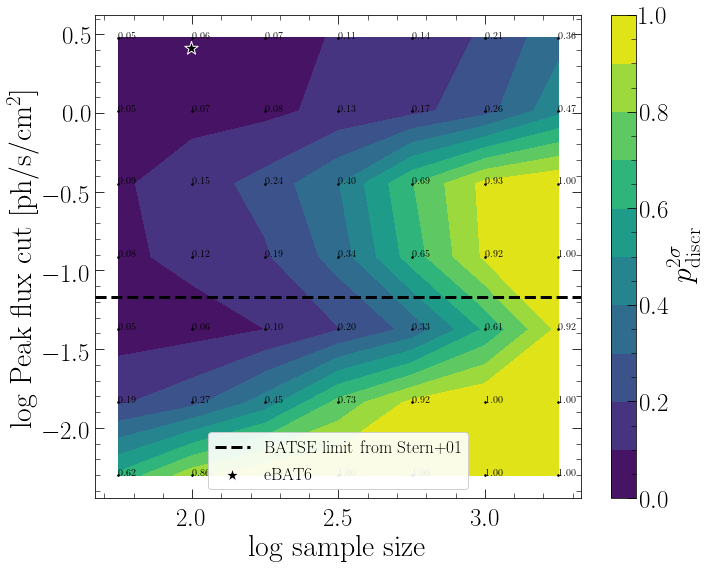

In [21]:
def plot_pflx_cut_vs_sample_size(size, pflx_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_pflx_cuts_2D = np.meshgrid(np.log10(size), np.log10(pflx_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_pflx_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(pflx_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(pflx_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(pflx_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Peak flux cut [ph/s/cm$^2$]")
    return

# Create the 2D plane 'pflx cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
for key, value in p_discr_z_BAT6.items():
    print(key)
    plot_pflx_cut_vs_sample_size(size, pflx_cuts, value, show_indiv_pts=True)
    ax = plt.gca()
    ax.scatter(np.log10(99), np.log10(2.6), s=200, marker='*', edgecolor='w', color='k', label='eBAT6')
    ax.axhline(np.log10(0.068), ls='--', color='k', label='BATSE limit from Stern+01')
    ax.legend(loc='best')
    plt.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/pflx_sampsize_{key}.pdf')
    plt.show()

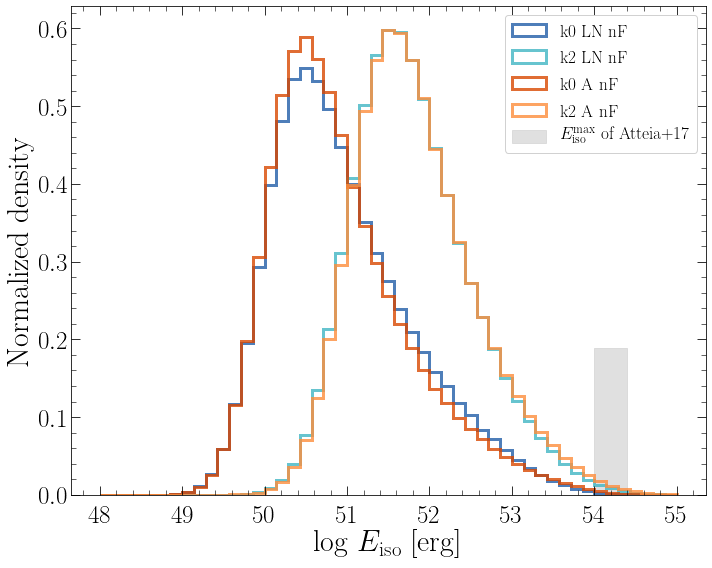

In [76]:
# Now we want to look at the Ep-Eiso plane and the Eiso distribution to compare with Atteia+17.
fig, ax = plt.subplots(figsize=(10,8))
from matplotlib.transforms import blended_transform_factory
tform = blended_transform_factory(ax.transData, ax.transAxes)
    
ax.fill_between([54,54.4], [0.3,0.3], transform=tform, color='lightgrey',
                alpha=0.7, label=r'$E^{\rm max}_{\rm iso}$ of Atteia+17')
for i, mod in enumerate(model_names_ks):
    ax.hist(np.log10(dfs[mod]['Eiso']), bins=np.linspace(48, 55, 50), histtype='step', linewidth=3,
            alpha=0.8, density=True, label=mod.replace('_',' '), color=colors[i])


ax.autoscale()
ax.legend(loc=0)
ax.set_ylabel(r'Normalized density')
ax.set_xlabel(r'log $E_{\rm iso}$ [erg]')
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/Eiso_distr.pdf',
            bbox_inches='tight')


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


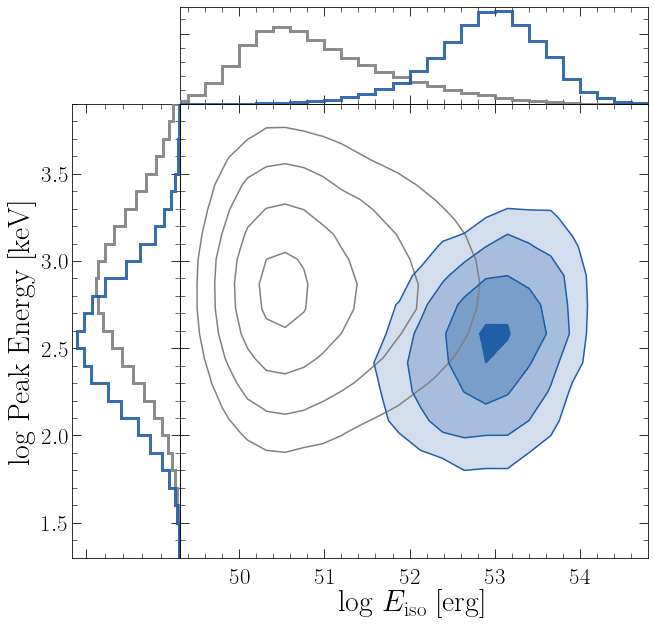

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


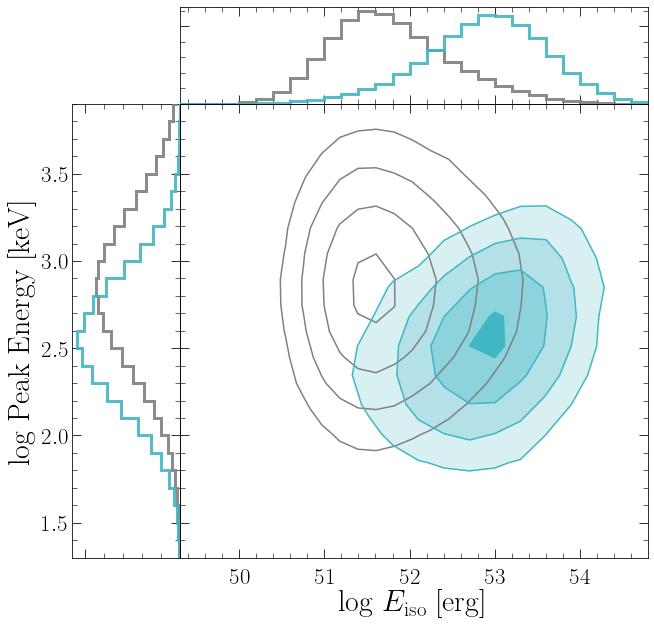

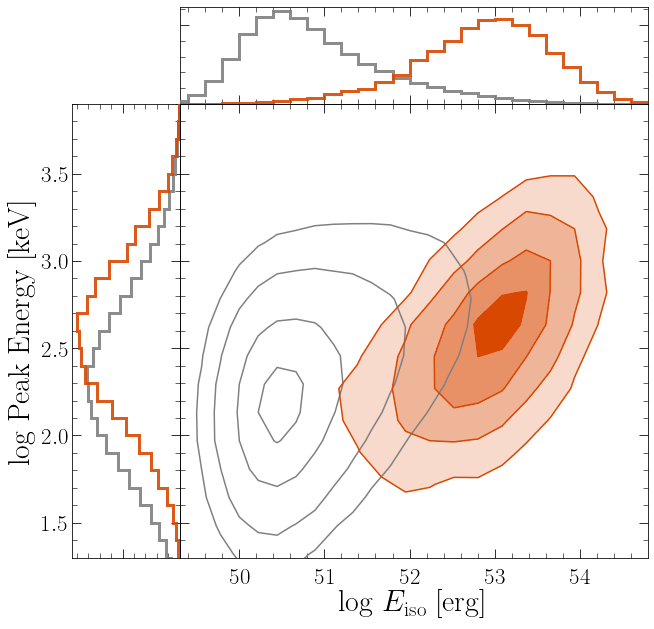

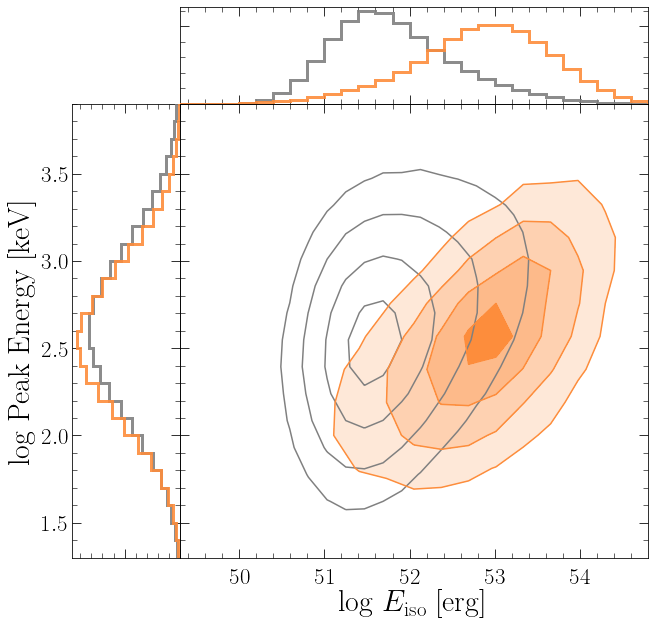

In [77]:
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(dfs[mod]['Eiso'].to_numpy()), np.log10(dfs[mod]['Ep'].to_numpy()),
               mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
               plot_left_hist=True, plot_top_hist=True,
               left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':'gray',
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': 'gray',
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
               hist2d_kwargs={'color':'gray', 'bins':30,
                              'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                              'plot_datapoints':False, 
                              'plot_density':False, 
                              'plot_contours':True,
                              'fill_contours':False})
    pf.cool_hist2d(np.log10(dfs[mod][cond]['Eiso'].to_numpy()), np.log10(dfs[mod][cond]['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, fig=fig, cb=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':colors[i],
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': colors[i],
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':colors[i], 
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    axes['left'].set_ylabel(r'log Peak Energy $\rm{[keV]}$')
    axes['center'].set_xlabel(r'log $E_{\rm iso}~\rm{[erg]}$')
    axes['center'].set_xlim(49.3,54.8)
    axes['center'].set_ylim(1.3, 3.9)
    axes['center'].tick_params(labelsize=23)
    axes['left'].tick_params(labelsize=23)

Sample size :1313
Sample size :78
Sample size :345


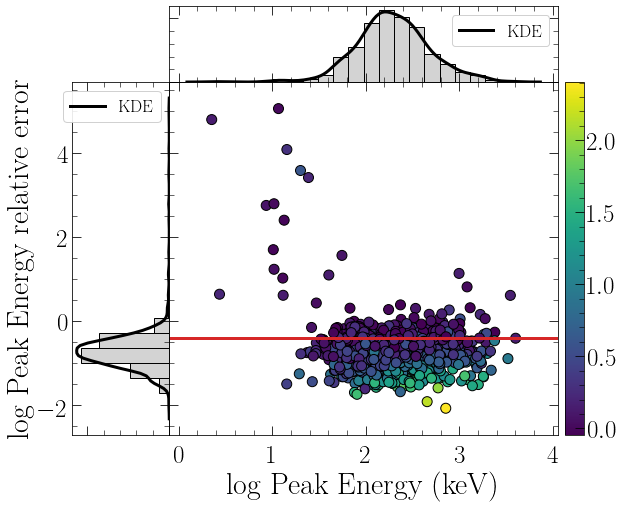

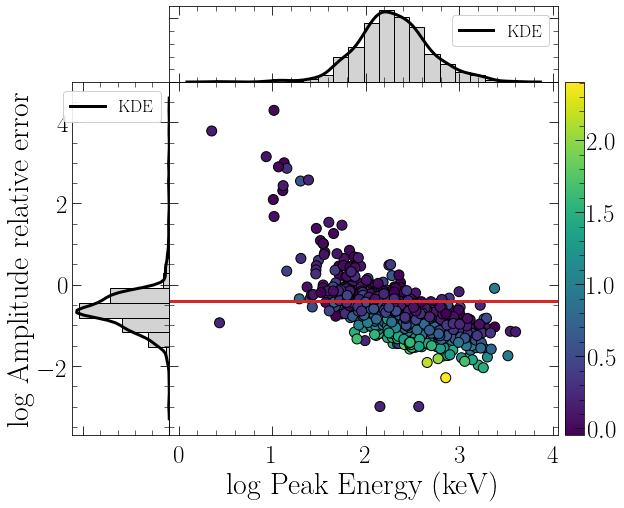

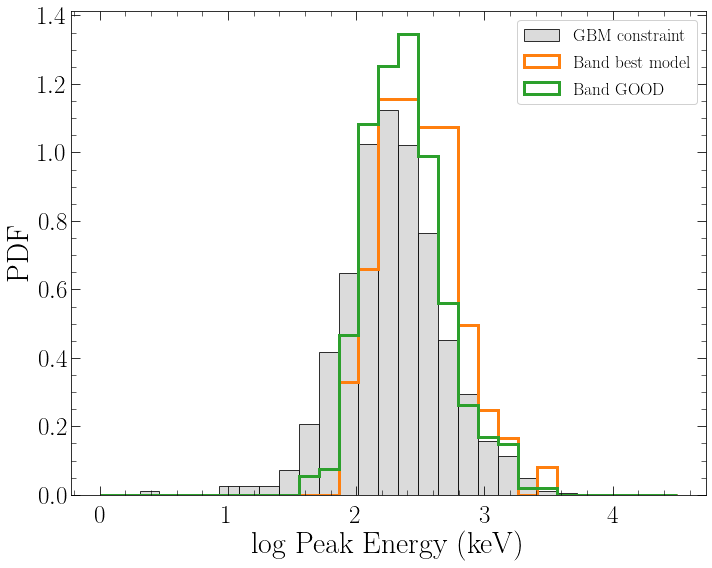

In [19]:
# This is to check if using the 'GOOD' criteria defined by Gruber+14 and Bhat+16 as low relative errors on Ep and on
# the amplitude of the Band spectrum fit introduces a bias against low or high Ep.
# Conclusion : YES the relative error on the amplitude is higher at low Ep than at high Ep

def calc_rel_errors_GBM_band(df_obs):
    # Calculate relative errors on Band parameters for later filtering
    keys =  ['pflx_band_epeak_pos_err','pflx_band_epeak', 'pflx_band_ampl_pos_err', 'pflx_band_ampl']
    for k in keys:
        df_obs[k] = pd.to_numeric(df_obs[k], errors='coerce')
    df_obs['pflx_band_epeak_rel_err'] = df_obs['pflx_band_epeak_pos_err']/df_obs['pflx_band_epeak']
    df_obs['pflx_band_ampl_rel_err'] = df_obs['pflx_band_ampl_pos_err']/df_obs['pflx_band_ampl']
    return df_obs

# Read the GBM data
df_obs = pd.read_csv('../catalogs/GBM_cat/fermi_GBM_cat_total.dat', sep='|', header=2, low_memory=False)
df_obs.rename(columns=lambda x:x.strip(), inplace=True)

# Filter out short and incomplete (low peak flux) GRBs
df_obs = msc.filter_df(df_obs, 't90', lim_min=2, errors='coerce')
df_obs = msc.filter_df(df_obs, 'pflx_band_phtfluxb', lim_min=0.9, errors='coerce')
# for i,col in enumerate(df_obs.columns):
#     print(i,col)
df_obs = calc_rel_errors_GBM_band(df_obs)
df_obs['pflx_band_ampl_rel_err'].replace(0,1e-3, inplace=True)

# Plot the Ep relative error vs Ep
fig, axes = pf.cool_hist2d(np.log10(df_obs['pflx_band_epeak']),
                           np.log10(df_obs['pflx_band_epeak_rel_err']),
                           c=np.log10(df_obs['pflx_band_phtfluxb']))
axes['center'].axhline(np.log10(0.4), color='C3')
axes['center'].set_xlabel('log Peak Energy (keV)')
axes['left'].set_ylabel('log Peak Energy relative error')

# Plot the Band amplitude relative error vs Ep
fig, axes = pf.cool_hist2d(np.log10(df_obs['pflx_band_epeak']),
                           np.log10(df_obs['pflx_band_ampl_rel_err']),
                           c=np.log10(df_obs['pflx_band_phtfluxb']))
axes['center'].axhline(np.log10(0.4), color='C3')
axes['center'].set_xlabel('log Peak Energy (keV)')
axes['left'].set_ylabel('log Amplitude relative error')



# Look at the GBM Ep distribution for different criteria :
# - all GRBs that are long and complete
# - when BAND is best fit model
# - all GRBs satisfying 'GOOD' criteria of Gruber+14 and Bhat+16 
# (i.e. with low errors on alpha and beta and low relative errors on Ep and the amplitude of the Band fit)
bins = np.linspace(0,4.5, 30)
fig, ax = plt.subplots(figsize=(10,8))
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='GBM constraint', alpha=0.8,
                  color='lightgray', errors='coerce')
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df for i in range(3)],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_best_fitting_model', 'equal':'pflx_band', 'string':True}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Band best model', linewidth=3, histtype='step',
                  color='C1', errors='coerce')
func_list = [calc_rel_errors_GBM_band]
func_list += [msc.filter_df for i in range(7)]
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=func_list,
                  func_args=[{},
                             {'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_alpha_pos_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_epeak_rel_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_ampl_rel_err', 'lim_max':0.4, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Band GOOD', linewidth=3, histtype='step',
                  color='C2', errors='coerce')
ax.legend()
ax.set_xlabel('log Peak Energy (keV)')
ax.set_ylabel('PDF')

plt.show()


Sample size :1313
Sample size :132


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Sample size :124
Sample size :819


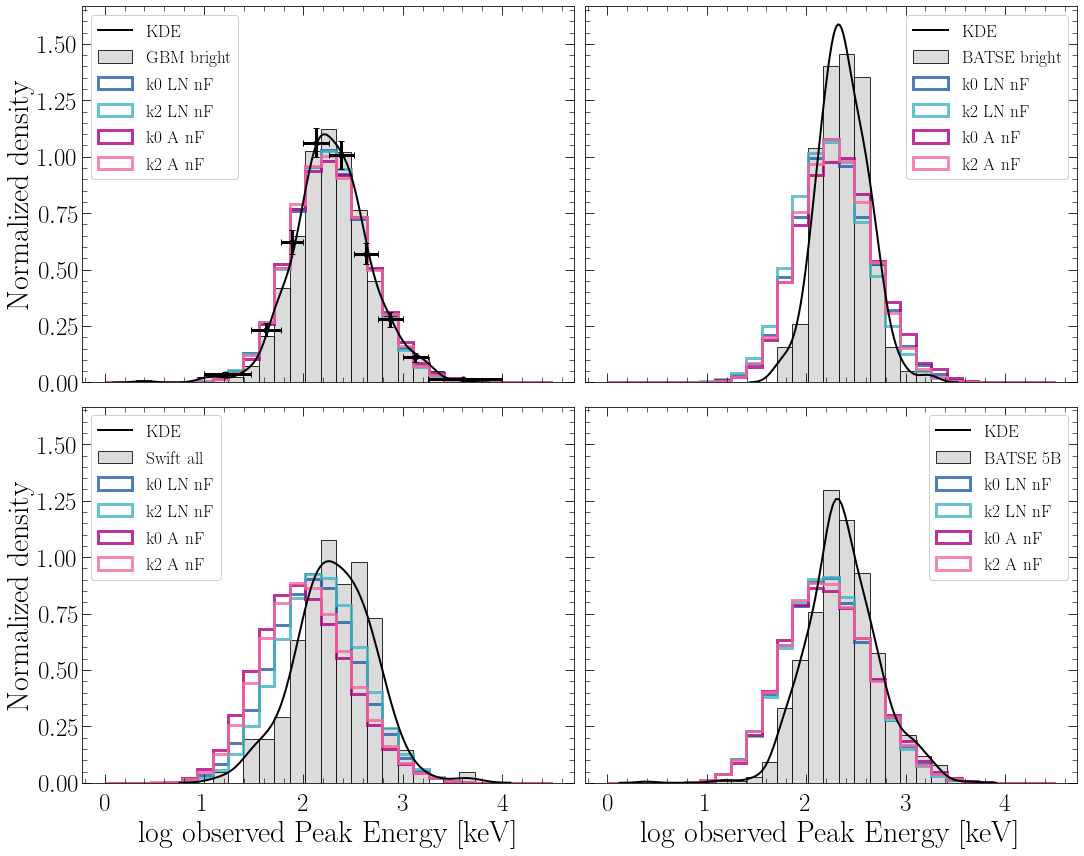

In [21]:
# Now look at Ep-L plane and Ep distributions of various observed samples to try to distinguish between
# Amati-like (intrinsic correlation) scenarios and LogNormal scenarios
bins = np.linspace(0,4.5, 30)
fig, axes = plt.subplots(2,2, figsize=(15,12), sharex='all', sharey='all')
ax = axes[0,0]
ax2 = axes[1,0]
ax3 = axes[0,1]
ax4 = axes[1,1]

# GBM bright
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax, density=True, label='GBM bright', alpha=0.8,
                  color='lightgray', errors='coerce')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pdet_EpGBM'] == 1
    ax.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))

ax.set_ylabel(r'Normalized density')
ax.legend(loc='upper left')


# Observational constraint
pf.plot_EpGBM(fname=paths_to_dir['root']/'observational_constraints/EpGBM_for_plotting.txt',
              ax=ax, density=True, log=True,
              linewidth=3, color='k', fmt='.', capsize=3)


# Swift
pf.plot_obs_property('../catalogs/Swift_cat/Swift_cat_complete.txt',
                  key='bat_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'bat_t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'bat_peakfluxp', 'lim_min':0.2, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax2, density=True, label='Swift all', alpha=0.8,
                  color='lightgray', errors='coerce')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 0.2
    ax2.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax2.set_xlabel(r'log observed Peak Energy $\rm{[keV]}$')
ax2.set_ylabel(r'Normalized density')
ax2.legend(loc='upper left')

# BATSE bright
pf.plot_obs_property('../catalogs/BATSE_cat/BATSE_bright_cat.txt',
                  key='peak_energy',
                  func=msc.filter_df,
                  func_args={'filtering_key':'spectral_model', 'equal':'BAND', 'string':True},
                  log=True, verbose=True, kde=True,
                  bins=np.linspace(0,4.5, 30),
                  ax=ax3, density=True, label='BATSE bright', alpha=0.8,
                  color='lightgray', errors='coerce')

for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BATSE'] >= 3.0
    ax3.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax3.legend()

# BATSE 20 - 2000 keV
pf.plot_obs_property('../catalogs/BATSE_cat/BATSE_cat_complete_5B.txt',
                  key='pflx_band_epeak',
                  func=msc.filter_df,
                  func_args={'filtering_key':'pflx_band_phtflux', 'lim_min':2.},
                  log=True, verbose=True, kde=True,
                  bins=np.linspace(0,4.5, 30),
                  ax=ax4, density=True, label='BATSE 5B', alpha=0.8,
                  color='lightgray', errors='coerce')

for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BATSE_5B'] >= 2.0
    ax4.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


ax4.set_xlabel(r'log observed Peak Energy $\rm{[keV]}$')
ax4.legend()





fig.subplots_adjust(hspace=0, wspace=0)
plt.show()



/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:82: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:83: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:84: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/pal

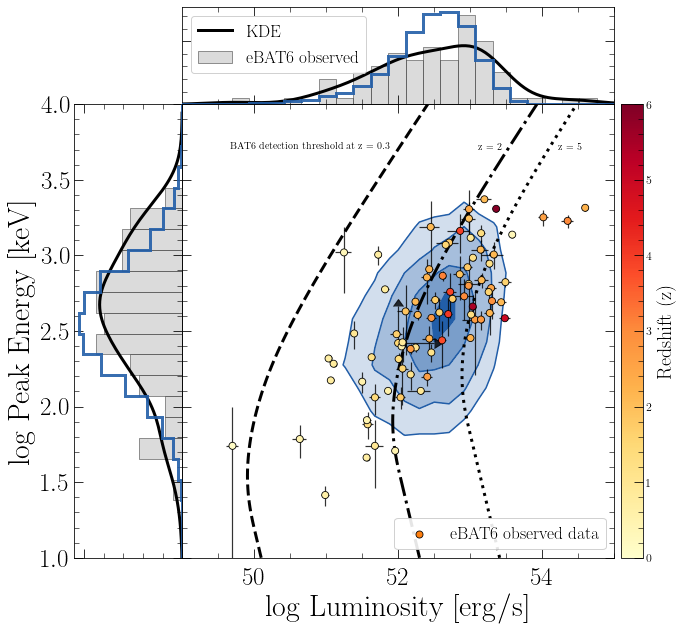

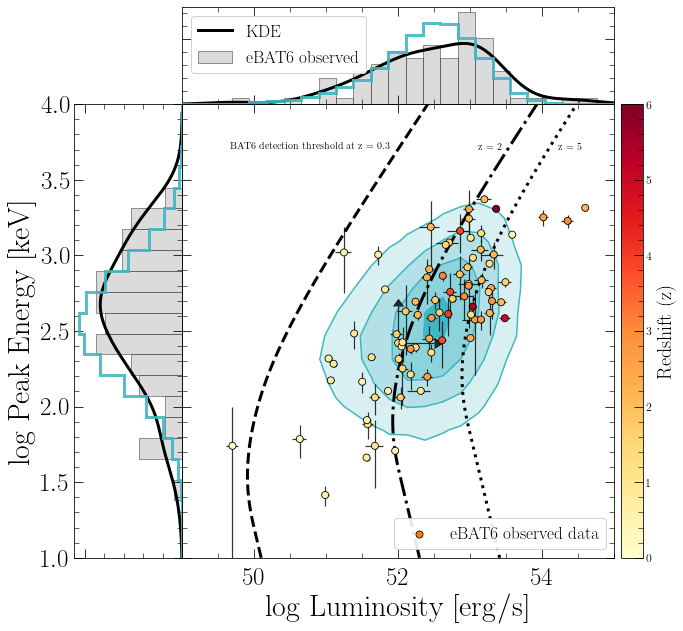

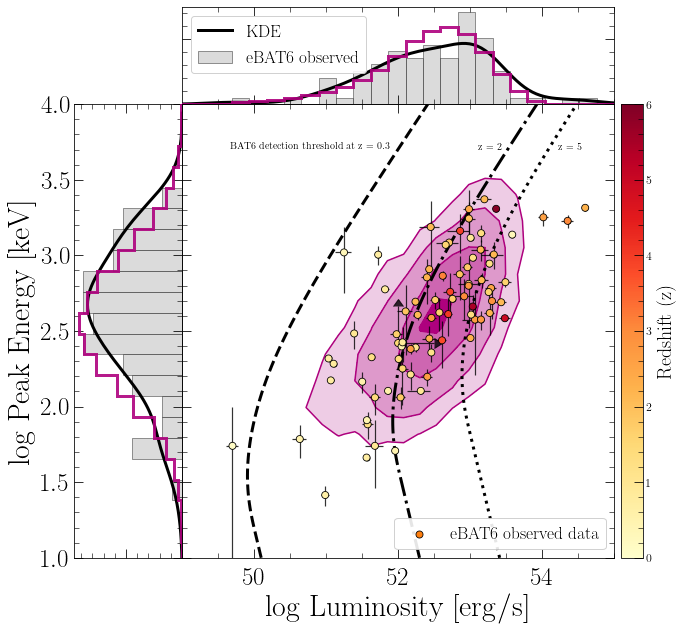

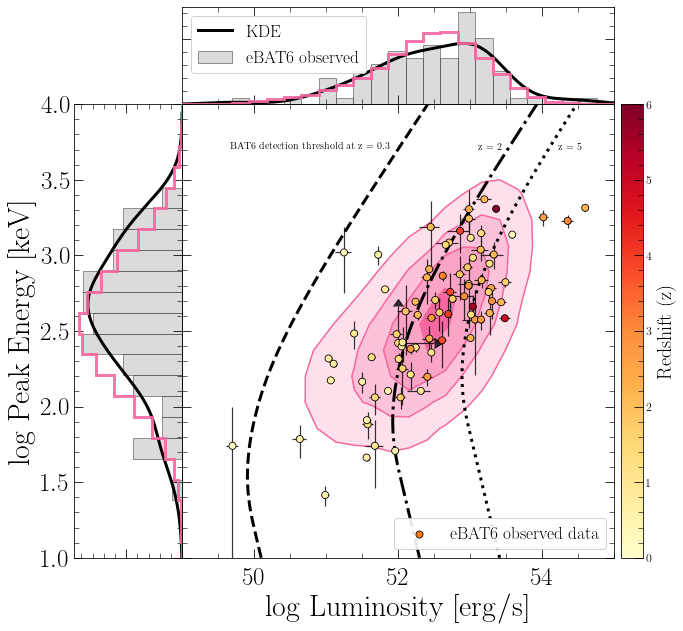

In [22]:
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(dfs[mod][cond]['L'].to_numpy()), np.log10(dfs[mod][cond]['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins': np.linspace(0,4,30),
                                     'edgecolor':colors[i],
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(48,55,30),
                                    'edgecolor': colors[i],
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':colors[i], 
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    pf.plot_eBAT6_EpL(axes=axes, mini_cax=False)


In [77]:
dfs[mod].columns

Index(['z', 'L', 'Ep', 't90obs', 'Cvar', 'alpha', 'beta', 'ktild', 'D_L',
       'Epobs', 'Eiso', 't90', 'pht_pflx_BATSE', 'pht_pflx_BAT',
       'pht_cts_ECLAIRs', 'erg_pflx_BATSE', 'erg_pflx_BAT', 'erg_cts_ECLAIRs',
       'pht_flnc_BATSE', 'pht_flnc_BAT', 'pht_flnc_ECLAIRs', 'erg_flnc_BATSE',
       'erg_flnc_BAT', 'erg_flnc_ECLAIRs', 'pdet_Stern', 'pdet_EpGBM',
       'pdet_eBAT6', 'pdet_Swift', 'pdet_ECLAIRs_tot', 'pdet_ECLAIRs_pht_flnc',
       'pdet_ECLAIRs_pht_cts', 'pdet_SHOALS', 'pht_pflx_GBM',
       'pht_pflx_BATSE_5B', 'erg_pflx_GBM', 'erg_pflx_BATSE_5B',
       'pht_flnc_GBM', 'pht_flnc_BATSE_5B', 'erg_flnc_GBM',
       'erg_flnc_BATSE_5B', 'pdet_GBM_sample', 'pdet_BATSE_5B_sample'],
      dtype='object')

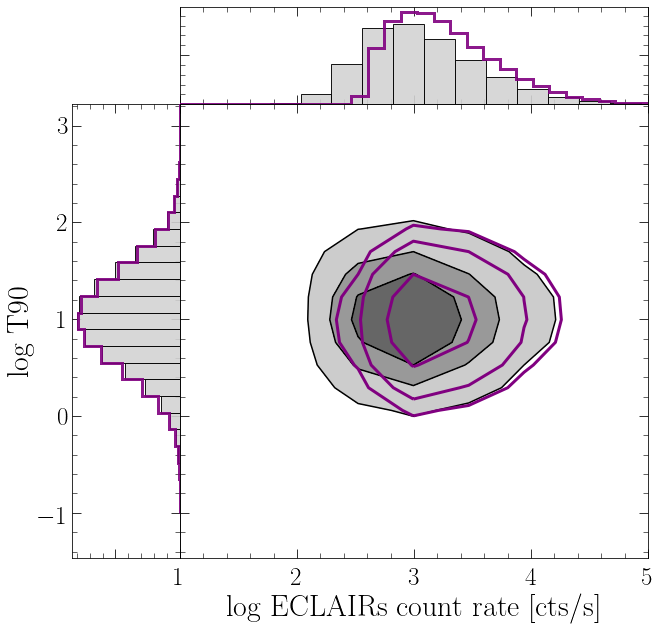

In [23]:
# Now lets look at the predictions for SVOM in more detail

# for mod in model_names_ks:
# fig, ax = plt.subplots(figsize=(10,9))
# bins_t90 = np.linspace(-1,4,30)
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_tot'],
#         color='lightgray', label='ECLAIRs population')
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_pht_flnc'],
#         color='darkorange', label='Fluence', alpha=0.5)
# ax.hist(np.log10(dfs[mod]['t90']), bins=bins_t90, weights=dfs[mod]['pdet_ECLAIRs_pht_cts'],
#         color='purple', label='Peak flux', alpha=0.5)
# ax.legend()
fig, axes = pf.cool_hist2d(np.log10(dfs[mod]['pht_cts_ECLAIRs'].to_numpy()),
                           np.log10(dfs[mod]['t90'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
                   left_hist_kwargs={'label': None,'weights':dfs[mod]['pdet_ECLAIRs_tot'],
                                     'bins': np.linspace(-1,4,30),
                                     'color':'lightgray',
                                     'zorder':5,
                                     'alpha':0.9},
                   top_hist_kwargs={'label': None,'weights':dfs[mod]['pdet_ECLAIRs_tot'],
                                    'bins': np.linspace(-3,6,35),
                                    'color':'lightgray',
                                    'zorder':5,
                                    'alpha':0.9},
                   hist2d_kwargs={'color':'k',
                                  'weights':dfs[mod]['pdet_ECLAIRs_tot'],
                                  'contour_kwargs':{'linewidths':1.5},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})

pf.cool_hist2d(np.log10(dfs[mod]['pht_cts_ECLAIRs'].to_numpy()),
                           np.log10(dfs[mod]['t90'].to_numpy()),
               fig=fig,
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False, cb=False,
                   left_hist_kwargs={'label': None,
                                     'bins': np.linspace(-1,4,30),
                                     'edgecolor':'purple', 'linewidth':3,
                                     'weights':dfs[mod]['pdet_ECLAIRs_pht_cts'],
                                     'zorder':5,
                                     'alpha':0.9, 'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(-0.5,5,40),
                                    'edgecolor':'purple', 'linewidth':3,
                                    'weights':dfs[mod]['pdet_ECLAIRs_pht_cts'],
                                    'zorder':5,
                                    'alpha':0.9, 'histtype':'step'},
                   hist2d_kwargs={'color':'purple', 'alpha':0.3,
                                  'weights':dfs[mod]['pdet_ECLAIRs_pht_cts'],
                                  'contour_kwargs':{'linewidths':3},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':False,'no_fill_contours':True})
axes['center'].set_xlim(1, 5)
axes['left'].set_ylabel('log T90')
axes['center'].set_xlabel('log ECLAIRs count rate [cts/s]')

plt.show()


In [17]:
fname = io.root_dir/'observational_constraints/Stern_lognlogp_rebinned.txt'
# fname = io.root_dir/'observational_constraints/Stern_lognlogp_rebinned_alternate.txt'
T_live_BATSE = 6.54  # years (Antier-Farfar thesis ?)
T_mission = 9.1  # years (Stern et al. 2001)
Omega_BATSE = 0.67 * 4. * np.pi  # years (Antier-Farfar thesis ?)

bins, hist_obs, err_obs = obs.create_Stern_hist(fname)
delta_bins = np.log10(bins[1:]/bins[:-1])
all_sky_glob_rate = np.sum(10**(hist_obs)*delta_bins)
# print(hist_obs)
# bin_midpoint = 0.5*(bins[:-1]+bins[1:])
# hist_obs_corrected = hist_obs / obs.efficiency_correction_Stern(bin_midpoint)
# print(hist_obs_corrected)

# N_GRB_BATSE_tot = np.sum(hist_obs_corrected)
# glob_rate = N_GRB_BATSE_tot / T_live_BATSE
# all_sky_glob_rate = glob_rate * Omega_BATSE

log.info(''.join([f"Global LGRB rate from Stern constraint: {all_sky_glob_rate:.2f} ",
         f"GRB/yr in 4 pi with peak flux in [50-300 keV] above {bins.min()} ph/s/cm2"]))


16:23:44.445 [INFO] Global LGRB rate from Stern constraint: 1137.95 GRB/yr in 4 pi with peak flux in [50-300 keV] above 0.06682496 ph/s/cm2


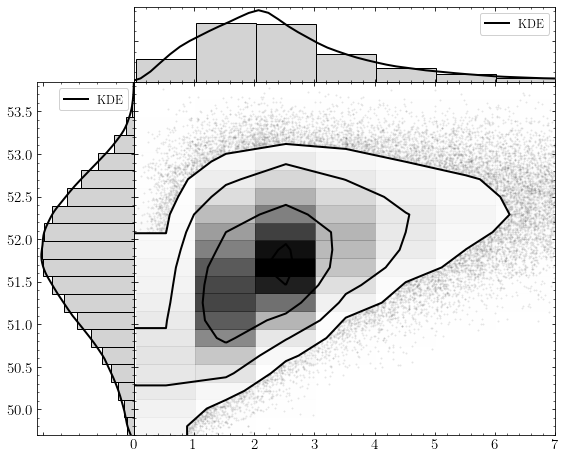

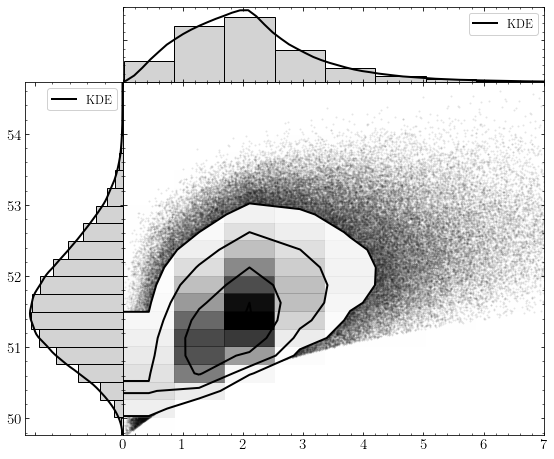

16:31:42.189 [INFO] 0.0 %. Size, fluence cut = 1000 1e-07
16:31:44.457 [INFO] Subsampling done in 0.678 s
16:31:52.942 [INFO] KS calculations done in 8.484 s
16:31:58.554 [INFO] CDF calculation done in 5.611 s
16:31:58.633 [WARNING] No handles with labels found to put in legend.
16:31:58.641 [WARNING] No handles with labels found to put in legend.
16:31:58.694 [INFO] Fraction of samples different at the 95% confidence level : 0.49
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
################# k2_A_nF #####################
D-stat, p_value = 0.073, 0.581
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
########

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


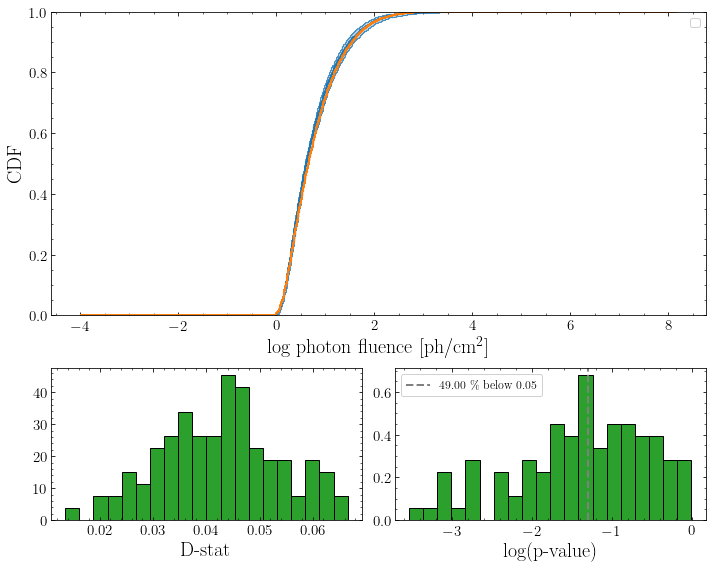

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


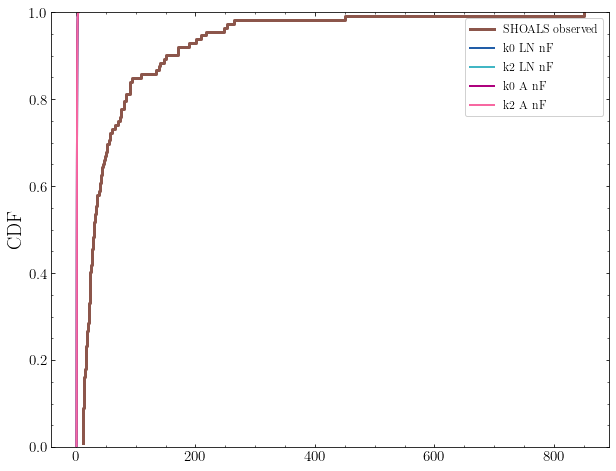

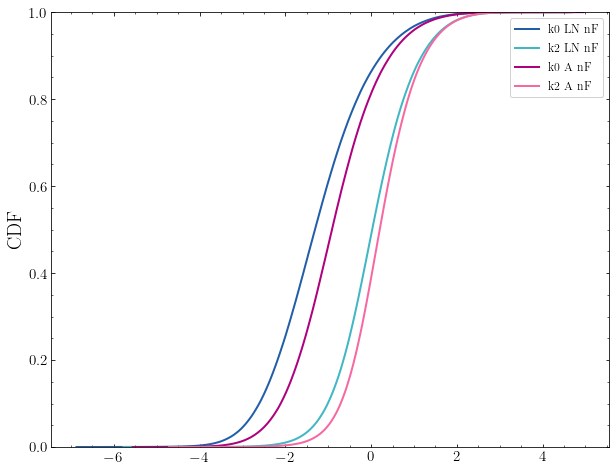

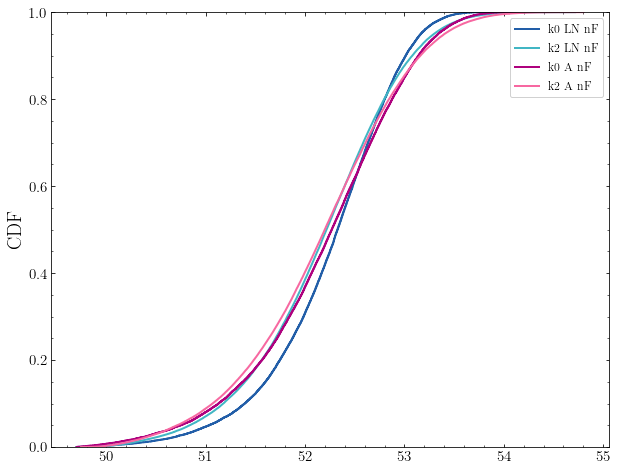

In [60]:
# All the things below are tests that didn't pan out
# Since just the redshift distribution of SHOALS doesn't help to discriminate much, maybe the L-z plane will
mod = 'k0_LN_nF'
cond = (dfs[mod]['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod][cond]['z'].to_numpy(),
               np.log10(dfs[mod][cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()



mod = 'k2_LN_nF'
cond = (dfs[mod]['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod][cond]['z'].to_numpy(),
               np.log10(dfs[mod][cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()

frac = np.zeros((len(size), len(flnc_cuts)))
k=0
# for i, j in product(range(len(size)), range(len(flnc_cuts))):
i=-1
j=-1
log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
frac[i,j]= st.subsample_and_KS(np.log10(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])]),
                             np.log10(dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])]),
                             key='pht_flnc_BAT',
                             precision=precision,
                             bins=np.linspace(-4,4,precision+1),
                             N_sub=size[i],
                             N_bs=100,
                             subsample2=False, show_plot=True)
log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
k+=1
plt.gcf().axes[0].set_xlabel('log photon fluence [ph/cm$^2$]')

p_discr_L['A'] = frac

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT']),
                          key='S_BAT',
                          plot_obs=(i==0),
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod]['pht_flnc_BAT']),
                          key='S_BAT',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the luminosity distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['L']),
                          key='L',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
